## Import libraries

In [1]:
# Import lybraries
import numpy as np #numerical computation package
import scipy as sp #library of scientific algorithms
# from scipy.integrate import odeint #to integrate ODEs
# from scipy.spatial.distance import pdist, squareform #to compute Recurrence Plot
# from scipy import signal #to decimate data
import pandas as pd #library to manipulate and arrange data properly
import sympy as sym #symbolic library
import time
from numba import jit #library to compile some functions
import numba #import this way to avoid problems with parallel computation...
import matplotlib.pyplot as plt #library to plot graphs
from mpl_toolkits.mplot3d import Axes3D #plot in 3D
%matplotlib inline
plt.rc('text', usetex=True) #to use Tex fonts in figures
import os.path #to verify existence of a file

## Common functions for phase sync analisys

In [2]:
# Function to integrate ODE using Runge Kutta - v002 (faster) - intRK2(odeFun, x0, t, args=()) 
def intRK2(odeFun, x0, t, args=()):
    """
    Runge-Kutta integration (same parameters as scipy.integrate.odeint)
    
    Inputs:
       - odeFun: (callable) ordinary differential equation, e.g. "x, t: odeFun(x, t)"
       - x0: vector of initial states, ex. "x0 = np.array([1.0, 0.3, 3.1])" for a 3D system
       - t: np.array containing the time stamps, ex "t=np.arange(0, 100, 0.02)"
    
    Outputs:
       - x: array of states, shape (len(t), len(x0))
       - t: array of time stamps, shape (len(t))
    
    IFMG - v002 - Leandro Freitas (dez-2020)
    """
    
    # pre-allocate state vector
    x = np.empty((len(t),len(x0))) #(len(t), len(x0))
    
    @jit(nopython=True)
    def auxFunc(x0, t, x, args):
        # initial state
        x[0, :] = x0

        # integration step
        dt = t[1]-t[0]

        # loop to compute the states
        for k in range(1, len(t)):
            k1F = dt*odeFun(x[k-1, :], t[k], *args)
            k2F = dt*odeFun(x[k-1, :] + k1F/2., t[k], *args)
            k3F = dt*odeFun(x[k-1, :] + k2F/2., t[k], *args)
            k4F = dt*odeFun(x[k-1, :] + k3F, t[k], *args)
            # compute the actual state
            x[k, :] = x[k-1, :] + (k1F+2.*k2F+2.*k3F+k4F)/6.

        return x
    
    return auxFunc(x0, t, x, args)

In [3]:
# Time between crossing of Poincaré section - f_timeBetCrossPoin(x, t, f_poin) 
def f_timeBetCrossPoin(x, t, f_poin):
    """
    Estimate time between crossings of a Poincaré section.
      Inputs:
        - x[M,n]: state variables of the system (M: #of points, n: #of states)
        - t[M]: time variable of the system (M: #of points)
        - f_poin(x[k,:], x[k-1,:]): function that receives two consecutive points
          and returns TRUE or FALSE accordding to the passage through the section.
          'TRUE' indicate that the section is between x[k] and x[k-1]
    
      Outputs:
        - timeBetCross[#of crossings-1]: computed time between crossings
        - crossIdx[#of crossings]: indices of crossing (size: #of crossings)
          (ex.: 'x[crossIdx]' shows the crossing points in the variable 'x')
        - numPass[M]: register #of passages through the section for each sample
          (ex.: 'numPass[80]' show how many crossing occured before the 80th sample)
    
    Versions:
        > MACSIN - v000 - LFA jul-2017
        > PRATICAR/IFMG - v001 - LFA dez-2020: vectorized implementation (@jit does not work)
    """
    
    # Passages through the Poincaré section
    passages = f_poin(x[:-1,:], x[1:,:]) # Note: len(passages) = len(x) - 1 (one less sample)
    crossTime = t[1:][passages] # must start in the second sample because shape of "passages"
    
    # compute the time between crossings (time to complete a cycle)
    timeBetCross = crossTime[1:]-crossTime[:-1]
    
    # index of crossings in the trajectory "x" and time "t"
    crossIdx = np.where(passages)[0]+1
    
    # number of passages through the section for each point
    numPass = np.cumsum(passages)
    numPass = np.append(numPass[0], numPass)
    
    return timeBetCross, crossIdx, numPass

In [4]:
# Phase calculation (Vector Field Phase) - f_estimateVFP(x, t, kkP1, kkP2, f_ode=None) 
def f_estimateVFP(x, t, kkP1, kkP2, f_ode=None):
    """
    Estimate VFP phase.
    
      Inputs:
        - x[N,2*n]: state variables of the system (N: #of samples, n: #of states)
        - t[N]: time variable of the system (M: #of samples)
        - kkP1: array of indexes that are in the Poincare section of the system (1)
        - kkP2: array of indexes that are in the Poincare section of the system (2)
        - f_ode: function that calculate vector field with 'x' as input argument f_ode(x)
                 if "f_ode" is "None", then the vector field is estimated
            
      Outputs:
        - phi_1, phi_2: phase variables of each subsystem
        - ell1, ell2: computed arc length of each revolution
        - freq1, freq2: frequency of each subsystem
    
    MACSIN - v000 - LFA mar-2018
    PRATICAR/IFMG - v001 - LFA dez-2020: faster implementation
    PRATICAR/IFMG - v002 - LFA fev-2021: bug fix
    """
    
    # interesting variables
    N = np.size(x, 0) #number of samples
    n = int(np.size(x, 1)/2) #order of each subsystem
    
    # Compute the arc-length (perimeter) for each revolution...
    #  - Oscillator (1)
    ell1 = np.empty(N)
    dist1 = np.linalg.norm(x[1:,:n]-x[:-1,:n], axis=1) #distance between each subsequent points
    for k in np.arange(len(kkP1)-1):
        ell1[kkP1[k]:kkP1[k+1]] = np.sum(dist1[kkP1[k]:kkP1[k+1]-1])
    # complete missing lengths
    ell1[:kkP1[0]]=ell1[kkP1[0]]; ell1[kkP1[-1]:]=ell1[kkP1[-1]-1];

    #  - Oscillator (2)
    ell2 = np.empty(N)
    dist2 = np.linalg.norm(x[1:,n:]-x[:-1,n:], axis=1) #distance between each subsequent points
    for k in np.arange(len(kkP2)-1):
        ell2[kkP2[k]:kkP2[k+1]] = np.sum(dist2[kkP2[k]:kkP2[k+1]-1])
    # complete missing lengths
    ell2[:kkP2[0]]=ell2[kkP2[0]]; ell2[kkP2[-1]:]=ell2[kkP2[-1]-1];
    
    # Compute the instantaneous frequency
    if f_ode is not None:
        # when vector field is available
        f = np.empty((N, 2*n))
        dt = np.mean(t[1:]-t[:-1])
        for k in np.arange(N): # len(k) => 0 to N-1
            f[k,:] = f_ode(x[k,:]) #using a "for loop" because "f_ode" is not vectorized...
        
        # Oscillator (1)
        freq1 = ( (2*np.pi)/ell1 ) * np.linalg.norm(f[:,:n], axis=1)
        f1 = freq1*np.append(dt, t[1:]-t[:-1]) #numerical integration (zero-order hold)
        
        # Oscillator (2)
        freq2 = ( (2*np.pi)/ell2 ) * np.linalg.norm(f[:,n:], axis=1)
        f2 = freq2*np.append(dt, t[1:]-t[:-1]) #numerical integration (zero-order hold)
        
    else:
        # when vector field is NOT available
        dt = np.mean(t[1:]-t[:-1])
        
        # Oscillator (1)
        f1 = ( (2*np.pi)/ell1[1:] ) * np.linalg.norm(x[1:,:n]-x[:-1,:n], axis=1) #estimate vector field
        f1 = np.append(f1[0], f1) #copy first element to keep len(f1) = N
        freq1 = f1/np.append(dt, t[1:]-t[:-1]) #instantaneous frequency
        
        # Oscillator (2)
        f2 = ( (2*np.pi)/ell2[1:] ) * np.linalg.norm(x[1:,n:]-x[:-1,n:], axis=1) #estimate vector field
        f2 = np.append(f2[0], f2) #copy first element to keep len(f2) = N
        freq2 = f2/np.append(dt, t[1:]-t[:-1]) #instantaneous frequency
    
    # Compute the VECTOR FIELD PHASE
    #   - Oscillator 1
    phi_1 = np.cumsum(f1)-f1[0]
    
    #   - Oscillator 2
    phi_2 = np.cumsum(f2)-f2[0]
    
    # return phase values (phi_1, phi_2), perimeters (ell1, ell2) and frequency (freq1, freq2)
    return phi_1, phi_2, ell1, ell2, freq1, freq2

In [5]:
# VFP calculation for 1 oscillator alone - f_estimateVFP_1(x, t, kkP1, f_ode=None) 
def f_estimateVFP_1(x, t, kkP1, f_ode=None):
    """
    Estimate VFP phase.
    
      Inputs:
        - x[N,n]: state variables of the system (N: #of samples, n: #of states)
        - t[N]: time variable of the system (M: #of samples)
        - kkP1: array of indexes that are in the Poincare section of the system
        - f_ode: function that calculate vector field with 'x' as input argument f_ode(x)
                 if "f_ode" is "None", then the vector field is estimated
            
      Outputs:
        - phi_1: phase variables of the system
        - ell1: computed arc length of each revolution
        - freq1: frequency of the system
    
    PRATICAR/IFMG - v000 - LFA jan-2021: initial version
    PRATICAR/IFMG - v001 - LFA fev-2021: bug fix
    """
    
    # interesting variables
    N = np.size(x, 0) #number of samples
    n = int(np.size(x, 1)) #order of the system
    
    # Compute the arc-length (perimeter) for each revolution...
    ell1 = np.empty(N)
    dist1 = np.linalg.norm(x[1:,:n]-x[:-1,:n], axis=1) #distance between each subsequent points
    for k in np.arange(len(kkP1)-1):
        ell1[kkP1[k]:kkP1[k+1]] = np.sum(dist1[kkP1[k]:kkP1[k+1]-1])
    # complete missing lengths
    ell1[:kkP1[0]]=ell1[kkP1[0]]; ell1[kkP1[-1]:]=ell1[kkP1[-1]-1];

    # Compute the instantaneous frequency
    if f_ode is not None:
        # when vector field is available
        f = np.empty((N, n))
        dt = np.mean(t[1:]-t[:-1])
        for k in np.arange(N): # len(k) => 0 to N-1
            f[k,:] = f_ode(x[k,:]) #using a "for loop" because "f_ode" is not vectorized...
        
        # Oscillator frequency
        freq1 = ( (2*np.pi)/ell1 ) * np.linalg.norm(f[:,:n], axis=1)
        f1 = freq1*np.append(dt, t[1:]-t[:-1]) #numerical integration (zero-order hold)
        
    else:
        # when vector field is NOT available
        dt = np.mean(t[1:]-t[:-1])
        
        # Oscillator frequency
        f1 = ( (2*np.pi)/ell1[1:] ) * np.linalg.norm(x[1:,:n]-x[:-1,:n], axis=1) #estimate vector field
        f1 = np.append(f1[0], f1) #copy first element to keep len(f1) = N
        freq1 = f1/np.append(dt, t[1:]-t[:-1]) #instantaneous frequency
        
    # Compute the VECTOR FIELD PHASE
    phi_1 = np.cumsum(f1)-f1[0]
    
    # return phase values (phi_1), perimeters (ell1) and frequency (freq1)
    return phi_1, ell1, freq1

## Oscillators (and their Poincaré sections)
#### Classics

In [6]:
# Rossler: Poincaré section ( x == (c - sqrt(c**2-4*a*b))/2 ) and (dx/dt > 0): f_rossler_poin(x1, x2,...)
def f_rossler_poin(x1, x2, a = .398, b = 2, c = 4):
    """"
    Poincare section proposed by Letellier, C., Dutertre, P., & Maheu, B. (1995). 10.1063/1.166076.
    
    Inputs:
        x1: state of the system to be verified if it is BEFORE the Poincare section
        x2: state of the system to be verified if it is AFTER the Poincare section
        x1.shape = x2.shape = (N, n=3), N: #of points, n=3: order of the system
    
    Default parameters:
       - a = .398, b = 2, c = 4
       - a = 0.165, b = 0.2, c = 10 (alternative)
    
    IFMG - v001 - LFA dez-2020: vectorized implementation
    """
    x1 = x1.reshape(-1, 3) # "3" represents the order of the system
    x2 = x2.reshape(-1, 3)
    xPoin = .5*(c-(c**2-4*a*b)**(.5))
    return (  ( ((x1[:,0]-xPoin)*(x2[:,0]-xPoin))<0 ) & (x2[:,0] > x1[:,0])  )

In [7]:
# Rössler oscillator: f_rossler(x, t, omg = 1, a = 0.165, b = 0.2, c = 10) 
@jit(nopython=True)
def f_rossler(x, t, omg = 1, a = 0.165, b = 0.2, c = 10):
    """
    Rössler oscillator (Rössler, 1976) - Phys. Lett. A, 57(5), 397–398.
        - x[0], x[1], x[2]: state variables sys.(1)  {dx = F(x)
        - t: time
    
    MACSIN - v000 - LFA jul-2017
    """   
    
    # ---------------------------------------------------
    # state vectors
    x1 = x[0]
    y1 = x[1]
    z1 = x[2]
    
    # ---------------------------------------------------
    # Rössler oscillator
    # omg = 1; a = 0.165; b = 0.2; c = 10; #parameters (1)
    return np.array([ -omg*y1-z1 , #drift vector field
                      omg*x1+a*y1 ,
                      b+z1*(x1-c) ])

In [8]:
# Two coupled Rossler systems: f_coupRossler(x, t, eps) 
@jit(nopython=True)
def f_coupRossler(x, t, eps):
    """
    Two coupled hyperchaotic Rossler oscillators:
        - x[0], x[1], x[2]: state variables sys.(1), Rossler
        - x[3], x[4], x[5]: state variables sys.(2), Rossler
        - t: time
        - eps: coupling strength
        - coupVar: coupling variable shape=(3,)
        
    IFMG - v000 - LFA dez-2020
    """   
    # state vectors and fixed parameters
    x1, y1, z1, x2, y2, z2 = x
    
    # SYSTEM (1)
    omg = .98; a = .398; b = 2; c = 4
    F1 = np.array([ -omg*y1-z1 , #drift vector field
                     omg*x1+a*y1 ,
                     b+z1*(x1-c)
    ])
    G1 = np.array([ eps[0]*(x2-x1) , #control vector field
                    eps[1]*(y2-y1) ,
                    eps[2]*(z2-z1)
    ])
    
    # SYSTEM (2)
    omg = 1.02; a = .398; b = 2; c = 4
    F2 = np.array([ -omg*y2-z2 , #drift vector field
                     omg*x2+a*y2 ,
                     b+z2*(x2-c)
    ])
    G2 = np.array([ eps[0]*(x1-x2) , #control vector field
                    eps[1]*(y1-y2) ,
                    eps[2]*(z1-z2)
    ])
    
    # Whole differential equations
    dx = np.hstack((F1 + G1, F2 + G2))
    
    return dx

In [9]:
# Two coupled Hyperchaotic Rossler systems: f_hyperChaosRossler_sync(x, t, eps) 
@numba.jit(nopython=True)
def f_hyperChaosRossler_sync(x, t, eps):
    """
    Two coupled hyperchaotic Rossler oscillators:
        - x[0], x[1], x[2], x[3]: state variables sys.(1), hyperchaotic Rossler
        - x[4], x[5], x[6], x[7]: state variables sys.(2), hyperchaotic Rossler
        - t: time
        - eps: coupling strength
        
        Initial conditions can be: x0 = −10; y0 = −6; z0 = 0; w0 = 10.0;
        
    MACSIN - v000 - LFA abr-2017
    """   
    # state vectors and fixed parameters
    x1, y1, z1, w1, x2, y2, z2, w2 = x
    
    # SYSTEM (1)
    a=0.25; b=3; c=0.5; d=0.05;
    F1 = np.array([ -y1 - z1 , #drift vector field
                    x1 + a*y1 + w1 ,
                    b + x1*z1 ,
                    -c*z1 + d*w1
    ])
    G1 = np.array([ (x2-x1) , #control vector field
                    (y2-y1) ,
                    (z2-z1) ,
                    (w2-w1)
    ])
    
    # SYSTEM (2)
    a=0.255; b=3; c=0.5; d=0.05;
    F2 = np.array([ -y2 - z2 , #drift vector field
                    x2 + a*y2 + w2 ,
                    b + x2*z2 ,
                    -c*z2 + d*w2
    ])
    G2 = np.array([ (x1-x2) , #control vector field
                    (y1-y2) ,
                    (z1-z2) ,
                    (w1-w2)
    ])
    
    # Whole differential equations
    dx = np.hstack((F1,F2)) + np.hstack((eps*G1,eps*G2))
    
    return dx

#### Proposed (old works)

In [10]:
# Coherent Funnel Attractor (modified Rössler): f_coherentFunnel(x, t, omg = 1, a = .3, b = .1, c = 8.5) 
@jit(nopython=True)
def f_coherentFunnel(x, t, omg = 1, a = .3, b = .1, c = 8.5):
    """
    Modified Rössler oscillator
        - x[0], x[1], x[2]: state variables sys.(1)  {dx = F(x)
        - t: time
    
    MACSIN - v000 - LFA jul-2017
    Phase coherence is not related to topology. PHYSICAL REVIEW E, v. 101, p. 032207, 2020.
    http://dx.doi.org/10.1103/PhysRevE.101.032207
    """   
    # state vectors
    x1 = x[0]
    y1 = x[1]
    z1 = x[2]
    
    # differential equation
    fx = np.array([ -omg*y1-z1 , #drift vector field
                     omg*x1+a*y1 ,
                     b+z1*(x1-c) ])
    
    # reparameterization of time
    hx = .546-.471*np.tanh((z1-25.5)/11)
    fx = hx*fx
    
    return fx

In [11]:
# Noncoherent Spiral Attractor (modified Rössler): f_noncoherentSpiral(x, t, omg = 1, a = .16, b = .1, c = 8.5) 
@jit(nopython=True)
def f_noncoherentSpiral(x, t, omg = 1, a = .16, b = .1, c = 8.5):
    """
    Modified Rössler oscillator
        - x[0], x[1], x[2]: state variables sys.(1)  {dx = F(x)
        - t: time
    
    MACSIN - v000 - LFA jul-2017
    Phase coherence is not related to topology. PHYSICAL REVIEW E, v. 101, p. 032207, 2020.
    http://dx.doi.org/10.1103/PhysRevE.101.032207
    """   
    # state vectors
    x1 = x[0]
    y1 = x[1]
    z1 = x[2]
    
    # differential equation
    fx = np.array([ -omg*y1-z1 , #drift vector field
                     omg*x1+a*y1 ,
                     b+z1*(x1-c) ])
    
    # reparameterization of time
    # hx = 21+25*np.tanh((z1-11)/10)
    # hx = 100.1+100*np.tanh((z1-21.5)/7)
    hx = 0.01 + 0.05*(x1**2 + y1**2)
    fx = hx*fx
    
    return fx

#### New Proposal

In [12]:
# Rossler-Z (modified Rössler): f_rosslerZ(x, t, omg = 1, a = .3, b = .1, c = 8.5) 
@jit(nopython=True)
def f_rosslerZ(x, t, omg = 1, a = .398, b = 2, c = 4):
    """
    Modified Rössler oscillator
        - x[0], x[1], x[2]: state variables sys.(1)  {dx = F(x)
        - t: time
        
        Spiral: omg = 1, a = .16, b = .1, c = 8.5
        Funnel: omg = 1, a = .3, b = .1, c = 8.5
        Other: omg = 1, a = .398, b = 2, c = 4 (lifted spiral attractor)
    IFMG - v000 - LFA dez-2020
    """   
    # state vectors
    x1 = x[0]
    y1 = x[1]
    z1 = x[2]
    
    # differential equation
    fx = np.array([ -omg*y1-z1 , #drift vector field
                     omg*x1+a*y1 ,
                     b+z1*(x1-c) ])
    
    # reparameterization of time
    # hx = .546-.471*np.tanh((z1-25.5)/11) #<== from previous paper http://dx.doi.org/10.1103/PhysRevE.101.032207
    # hx = .546-.471*np.tanh((z1-1)/1)
    # hx = 5.546-5.471*np.tanh((z1-1)/1)

    hx = 5.5-5.4*np.tanh((z1-1)/1)
    fx = hx*fx
    
    return fx

In [13]:
# Two coupled Rossler-Z systems: f_coupRosslerZ(x, t, eps) 
@jit(nopython=True)
def f_coupRosslerZ(x, t, eps):
    """
    Two coupled hyperchaotic Rossler oscillators:
        - x[0], x[1], x[2]: state variables sys.(1), Rossler-Z (modified Rossler)
        - x[3], x[4], x[5]: state variables sys.(2), Rossler-Z (modified Rossler)
        - t: time
        - eps: coupling strength
        
    MACSIN - v000 - LFA abr-2017
    """   
    # state vectors and fixed parameters
    x1, y1, z1, x2, y2, z2 = x
    
    # SYSTEM (1)
    omg = 1; a = .398; b = 2; c = 4
    F1 = np.array([ -omg*y1-z1 , #drift vector field
                     omg*x1+a*y1 ,
                     b+z1*(x1-c)
    ])
    G1 = np.array([ eps[0]*(x2-x1) , #control vector field
                    eps[1]*(y2-y1) ,
                    eps[2]*(z2-z1)
    ])
    
    # SYSTEM (2)
    omg = 1; a = .398; b = 2; c = 4
    F2 = np.array([ -omg*y2-z2 , #drift vector field
                     omg*x2+a*y2 ,
                     b+z2*(x2-c)
    ])
    G2 = np.array([ eps[0]*(x1-x2) , #control vector field
                    eps[1]*(y1-y2) ,
                    eps[2]*(z1-z2)
    ])
    
#     # reparameterization of time ####################<=== OLD
#     hx1 = 5.546-5.471*np.tanh((z1-1)/1)
#     F1 = hx1*F1
#     hx2 = 5.546-5.471*np.tanh((z2-1)/1)
#     F2 = hx2*F2
    
    # reparameterization of time
    hx1 = 5.5-5.4*np.tanh((z1-1)/1)
    F1 = hx1*F1
    hx2 = 5.5-5.4*np.tanh((z2-1)/1)
    F2 = hx2*F2
    
    # Whole differential equations
    dx = np.hstack((F1 + G1, F2 + G2))
    
    return dx

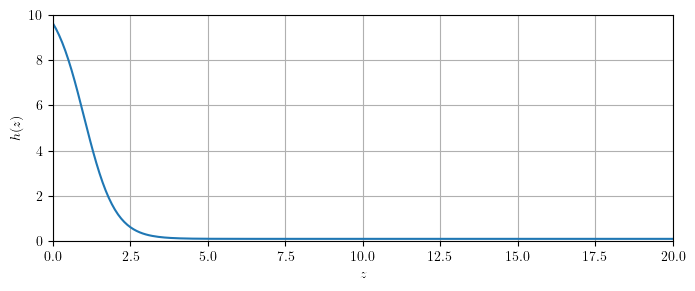

In [14]:
# The modified Rossler, curve plot
z1 = np.arange(0, 50, .1)
# hx = .546-.471*np.tanh((z1-1)/1)
hx = 5.5-5.4*np.tanh((z1-1)/1)
# hx = 5.1-5*np.tanh((z1-1)/1)

plt.figure(figsize=(8,3), dpi=100)
plt.plot(z1, hx)
plt.ylabel("$h(z)$")
plt.xlabel("$z$")
plt.axis([0, 20, 0, 10])
plt.grid(which="both")
plt.show()

## MODIFIED ROSSLER: preliminarly simulation of a single oscillators

In [15]:
# Simulation 
# PARAMETERS
h = .01 #integration step (h=0.001)
tf = 5000 #final time
n = 3 #system order
# omg = 1; a = .16; b = .1; c = 8.5 #parameters
omg = 1; a = .398; b = 2; c = 4 #parameters

# TRANSIENT SIMULATION
np.random.seed(1986)
x0tr = 1*np.random.rand(n) #random initial condition
tTr = np.arange(0, 500, h) #transient period (300seg: approx. 50 voltas no atrator)
xTr = intRK2(f_rosslerZ, x0tr, tTr, (omg, a, b, c)) #simulate the systems without coupling
xTr = intRK2(f_rosslerZ, xTr[-1], tTr, (omg, a, b, c)) #simulate COUPLED systems

# SIMULATION on permanent regime
T1 = np.arange(0, tf, h) #time range
X1 = intRK2(f_rosslerZ, xTr[-1], T1, (omg, a, b, c)) #use 'intRK' or 'odeint'

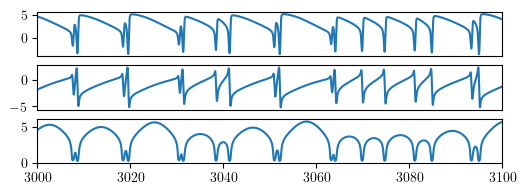

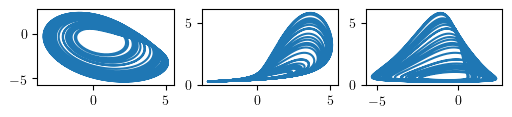

In [16]:
# Plot
%matplotlib inline
# %matplotlib widget

fig = plt.figure(figsize=(6,2), dpi=100)
plt.subplot(311)
plt.plot(T1, X1[:,0])
plt.xlim(3000, 3100)
plt.xticks([])

# fig = plt.figure(figsize=(6,1), dpi=100)
plt.subplot(312)
plt.plot(T1, X1[:,1])
plt.xlim(3000, 3100)
plt.xticks([])

# fig = plt.figure(figsize=(6,1), dpi=100)
plt.subplot(313)
plt.plot(T1, X1[:,2])
plt.xlim(3000, 3100)
plt.show();

fig = plt.figure(figsize=(6,1), dpi=100)
plt.subplot(131)
plt.plot(X1[:15000,0], X1[:15000,1])
plt.subplot(132)
plt.plot(X1[:15000,0], X1[:15000,2])
plt.subplot(133)
plt.plot(X1[:15000,1], X1[:15000,2])
plt.show()

# fig = plt.figure(figsize=(3,2), dpi=100)
# plt.axes(projection='3d')
# plt.plot(X1[:15000,0], X1[:15000,1], X1[:15000,2])
# plt.show()

## ROSSLER ("classical"): simulation of coupled oscillators

In [17]:
# Simulation 
# PARAMETERS
h = .01 #integration step (h=0.001)
tf = 5000 #final time
eps = np.array([0, 0, 0.1]) #coupling strength for each variable
n = 3

# TRANSIENT SIMULATION
np.random.seed(2021)
x0tr = 1*np.random.rand(2*n) #random initial condition
tTr = np.arange(0, 500, h) #transient period (300seg: approx. 50 voltas no atrator)
xTr = intRK2(f_coupRossler, x0tr, tTr, (0*eps,)) #simulate the systems without coupling
xTr = intRK2(f_coupRossler, xTr[-1], tTr, (eps,)) #simulate COUPLED systems

# SIMULATION on permanent regime
T1 = np.arange(0, tf, h) #time range
X1 = intRK2(f_coupRossler, xTr[-1], T1, (eps,)) #use 'intRK' or 'odeint'

In [18]:
# PHASE VARIABLE - compute VFP
timeBetCross_1, crossIdx_1, numPass_1 = f_timeBetCrossPoin(X1[:,:n], T1, f_rossler_poin)
timeBetCross_2, crossIdx_2, numPass_2 = f_timeBetCrossPoin(X1[:,n:], T1, f_rossler_poin)

# Phase variable (Poincaré section)
phi_a_1 = np.interp(T1, T1[crossIdx_1], 2*np.pi*np.arange(len(crossIdx_1)))
phi_a_2 = np.interp(T1, T1[crossIdx_2], 2*np.pi*np.arange(len(crossIdx_2)))

# Phase variable (VFP)
tic = time.time()
phi_1, phi_2, ell1, ell2, freq1, freq2 = f_estimateVFP(X1, T1, crossIdx_1, crossIdx_2,
                                                       lambda x: f_coupRossler(x=x, t=0, eps=eps))
toc = time.time()
print(toc-tic)

2.2830240726470947


Set experiment number

In [20]:
# CLASS: syncExperiment, with the appropriate functions 
class syncExperiment:
    def __init__(self, descricao=""):
        """
        Class used to concentrate data of an experiment.
        """
        self.descricao = descricao
        print("Object created.")
    
    ############################################################
    # SIMULATION FUNCTIONS
    def simulate(self, ode, eps, dt, x0tr, n=3, tfTr=500, tf=5000):
        # PARAMETERS
        self.ode = ode #ordinary differential equation
        self.eps = eps #coupling strength
        self.dt = dt #integration step
        self.x0tr = x0tr #initial condition
        self.n = n #order of the oscillator(s)
        self.tfTr = tfTr #duration of the TRANSIENT regime
        self.tf = tf #duration of the PERMANENT regime
        
        # TRANSIENT simulation
        print("Running transient simulation...")
        self.tTr = np.arange(0, self.tfTr, self.dt) #transient
        self.xTr = intRK2(self.ode, self.x0tr, self.tTr, (0*self.eps,)) #simulate the systems without coupling
        self.xTr = intRK2(self.ode, self.xTr[-1], self.tTr, (self.eps,)) #simulate COUPLED systems
        
        # SIMULATION on permanent regime
        print("Running permanent regime simulation...")
        self.T = np.arange(0, self.tf, self.dt) #time range
        self.X = intRK2(self.ode, self.xTr[-1], self.T, (self.eps,)) #use 'intRK' or 'odeint'
        print("End of simulation.")
        
    def computeVFP(self, f_poincare):
        self.poincare = f_poincare #function to compute Poincare section
        
        print("Computing vector field phase (VFP)...")
        # PHASE VARIABLE - compute VFP
        self.timeBetCross_1, self.crossIdx_1, self.numPass_1 = f_timeBetCrossPoin(
            self.X[:,:self.n], self.T, self.poincare)
        self.timeBetCross_2, self.crossIdx_2, self.numPass_2 = f_timeBetCrossPoin(
            self.X[:,self.n:], self.T, self.poincare)
        
        # Phase variable (Poincaré section)
        self.phi_a_1 = np.interp(self.T, self.T[self.crossIdx_1], 2*np.pi*np.arange(len(self.crossIdx_1)))
        self.phi_a_2 = np.interp(self.T, self.T[self.crossIdx_2], 2*np.pi*np.arange(len(self.crossIdx_2)))

        # Phase variable (VFP)
        self.vfp_1, self.vfp_2, self.ell1, self.ell2, self.freq1, self.freq2 = f_estimateVFP(
            self.X, self.T, self.crossIdx_1, self.crossIdx_2, lambda x: self.ode(x=x, t=0, eps=self.eps))
        print("VFP computed.")
    
    ############################################################
    # PERFORMANCE FUNCTIONS
    def syncMetrics(self):
        # VFP based metrics
        phDiff = self.vfp_1 - self.vfp_2
        # Mean Phase Coherence (ref: https://doi.org/10.1016/S0167-2789(00)00087-7)
        self.VFP_Rcoh = np.sqrt( np.mean(np.sin(np.abs(phDiff)))**2 + np.mean(np.cos(np.abs(phDiff)))**2 )
        # Max Absolute phase difference
        self.VFP_maxDiff = np.max(np.abs(phDiff))
        self.VFP_meanDiff = np.mean(phDiff) #mean phase diff
        self.VFP_stdDiff = np.var(phDiff) #variance of the phase diff
        
        # Poincaré phase metrics (same metrics above)
        phDiff = self.phi_a_1 - self.phi_a_2
        self.phi_a_Rcoh = np.sqrt( np.mean(np.sin(np.abs(phDiff)))**2 + np.mean(np.cos(np.abs(phDiff)))**2 )
        self.phi_a_maxDiff = np.max(np.abs(phDiff))
        self.phi_a_meanDiff = np.mean(phDiff)
        self.phi_a_stdDiff = np.var(phDiff)
    
    ############################################################
    # DATA VISUALIZATION PROCEDURES
    def plotPhaseDiffVFP(self):
        fig = plt.figure(figsize=(6,1), dpi=150)
        plt.title("Phase difference (VFP) $\epsilon_x=%.3f$, $\epsilon_y=%.3f$, $\epsilon_z=%.3f$"%
                  (self.eps[0], self.eps[1], self.eps[2]))
        plt.plot(self.T, self.vfp_1-self.vfp_2)
        plt.ylabel("VFP phase diff")
        plt.xlabel("$t$")
        plt.xlim(min(self.T), max(self.T))
        
    def plotPhaseDiffPoin(self):
        fig = plt.figure(figsize=(6,1), dpi=150)
        plt.title("Phase difference (Poincaré) $\epsilon_x=%.3f$, $\epsilon_y=%.3f$, $\epsilon_z=%.3f$"%
                  (self.eps[0], self.eps[1], self.eps[2]))
        plt.plot(self.T, self.phi_a_1-self.phi_a_2)
        plt.ylabel("Poin phase diff")
        plt.xlabel("$t$")
        plt.xlim(min(self.T), max(self.T))
        

In [26]:
# CLASS: syncExpToSave, where only the main informations are saved (exclude simulated)
class syncExpToSave():
    def __init__(self, exp):
        """
        Class used to save an experiment with using low memory.
        The vectors of time, states, phase, are not included.
        """
        self.descricao = exp.descricao
        self.ode = exp.ode
        self.eps = exp.eps
        self.dt = exp.dt
        self.x0tr = exp.x0tr
        self.n = exp.n
        self.tfTr = exp.tfTr
        self.tf = exp.tf
        self.tTr = exp.tTr
        self.xTr = exp.xTr
        self.poincare = exp.poincare
        
        self.VFP_Rcoh = exp.VFP_Rcoh
        self.VFP_maxDiff = exp.VFP_maxDiff
        self.VFP_meanDiff = exp.VFP_meanDiff
        self.VFP_stdDiff = exp.VFP_stdDiff
        self.phi_a_Rcoh = exp.phi_a_Rcoh
        self.phi_a_maxDiff = exp.phi_a_maxDiff
        self.phi_a_meanDiff = exp.phi_a_meanDiff
        self.phi_a_stdDiff = exp.phi_a_stdDiff
        
        print("syncExpToSave object created.")
    
    def createSyncExp(self):
        """
        Function to creat a "sync experiment" object based on the "syncExpToSave" object.
        """
        # Create "sync experiment" object
        exp = syncExperiment()

        # Run Simulation!
        exp.simulate(ode=self.ode,
                     eps=self.eps,
                     dt=self.dt, x0tr=self.x0tr, n=self.n, tfTr=self.tfTr, tf=self.tf)

        # Compute VFP
        exp.computeVFP(f_poincare=self.poincare)

        # Compute sync metrics
        exp.syncMetrics()
        
        return exp

In [23]:
# Sync Experiment

# Initial condition
n = 3
np.random.seed(2021)
x0tr = 1*np.random.rand(2*n) #random initial condition

# Create "sync experiment" object
exp1 = syncExperiment()

# Run Simulation!
exp1.simulate(ode=f_coupRossler,
              eps=np.array([0.0, 0.0, 0.7]),
              dt=.01, x0tr=x0tr, n=n, tfTr=500, tf=5000)

# Compute VFP
exp1.computeVFP(f_poincare=f_rossler_poin)

# Compute sync metrics
exp1.syncMetrics()

exp1.VFP_Rcoh

Object created.
Running transient simulation...
Running permanent regime simulation...
End of simulation.
Computing vector field phase (VFP)...
VFP computed.


0.2761766319429522

#### O que fazer agora:
1. Estabelecer forma de salvar os arquivos com resultados...ok!
1. Testar forma de salvar arquivos
1. Implementar Monte Carlo runs
1. Implementar processamento paralelo

In [199]:
# Function to save an object
# ref: https://stackoverflow.com/questions/4529815/saving-an-object-data-persistence
# import pickle as pickle
import _pickle as pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, protocol=-1) # '-1' is like 'HIGHEST_PROTOCOL'

# sample usage
save_object(exp1, 'exp1.pkl')


### Analysis

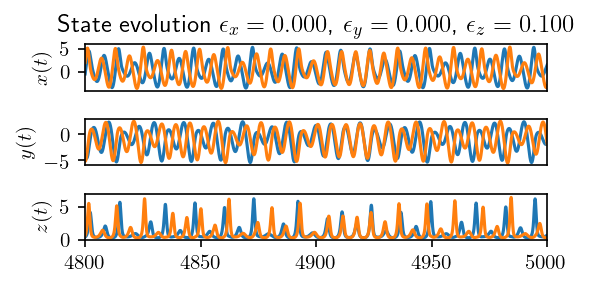

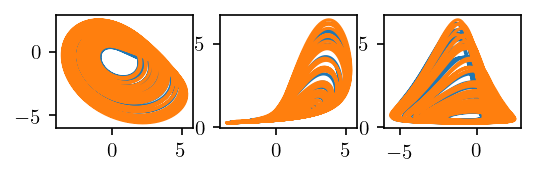

In [19]:
# Plot STATE EVOLUTION 
%matplotlib inline
# %matplotlib widget
plt_tempo = 4800, 5000
plt_att = (T1>plt_tempo[0])&(T1<plt_tempo[1])

fig = plt.figure(figsize=(4,2), dpi=150)
plt.subplot(311)
plt.title("State evolution $\epsilon_x=%.3f$, $\epsilon_y=%.3f$, $\epsilon_z=%.3f$"%(eps[0], eps[1], eps[2]))
plt.plot(T1, X1[:,0])
plt.plot(T1, X1[:,3])
plt.ylabel("$x(t)$")
plt.xlim(plt_tempo)
plt.xticks([])

# fig = plt.figure(figsize=(6,1), dpi=150)
plt.subplot(312)
plt.plot(T1, X1[:,1])
plt.plot(T1, X1[:,4])
plt.ylabel("$y(t)$")
plt.xlim(plt_tempo)
plt.xticks([])

# fig = plt.figure(figsize=(6,1), dpi=150)
plt.subplot(313)
plt.plot(T1, X1[:,2])
plt.plot(T1, X1[:,5])
plt.ylabel("$z(t)$")
plt.xlim(plt_tempo)
plt.tight_layout(1)

############################################################################
# SAVE FIGURE
# plt.savefig('fig/modifiedRossler_z_eps_0_1.pdf', format='pdf', dpi=150)
############################################################################

fig = plt.figure(figsize=(4,1), dpi=150)
plt.subplot(131)
plt.plot(X1[plt_att,0], X1[plt_att,1])
plt.plot(X1[plt_att,3], X1[plt_att,4])
plt.subplot(132)
plt.plot(X1[plt_att,0], X1[plt_att,2])
plt.plot(X1[plt_att,3], X1[plt_att,5])
plt.subplot(133)
plt.plot(X1[plt_att,1], X1[plt_att,2])
plt.plot(X1[plt_att,4], X1[plt_att,5])
plt.show()

# fig = plt.figure(figsize=(3,2), dpi=150)
# plt.axes(projection='3d')
# plt.plot(X1[:15000,0], X1[:15000,1], X1[:15000,2])
# plt.show()



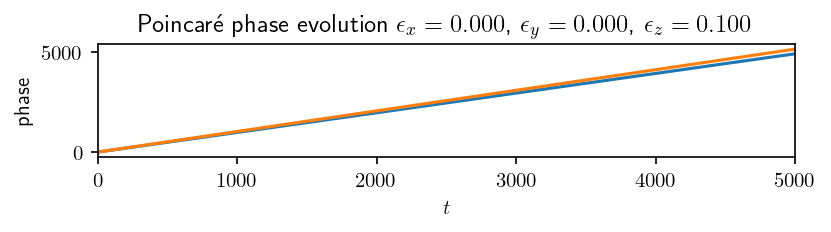

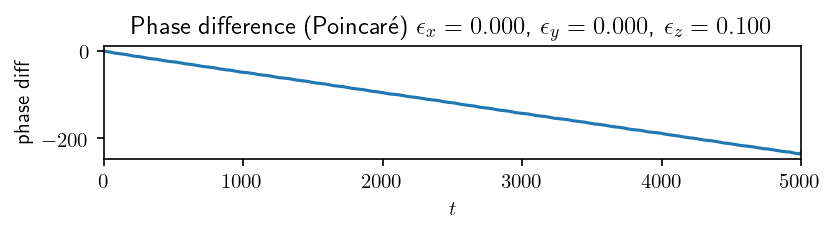

In [20]:
# Plot POINCARE phase EVOLUTION 
%matplotlib inline

plt_tempo = 0, 5000
plt_att = (T1>plt_tempo[0])&(T1<plt_tempo[1])

fig = plt.figure(figsize=(6,1), dpi=150)
plt.title("Poincaré phase evolution $\epsilon_x=%.3f$, $\epsilon_y=%.3f$, $\epsilon_z=%.3f$"%(eps[0], eps[1], eps[2]))
plt.plot(T1, phi_a_1)
plt.plot(T1, phi_a_2)
plt.ylabel("phase")
plt.xlabel("$t$")
plt.xlim(plt_tempo)

fig = plt.figure(figsize=(6,1), dpi=150)
plt.title("Phase difference (Poincaré) $\epsilon_x=%.3f$, $\epsilon_y=%.3f$, $\epsilon_z=%.3f$"%(eps[0], eps[1], eps[2]))
plt.plot(T1, phi_a_1-phi_a_2)
plt.ylabel("phase diff")
plt.xlabel("$t$")
plt.xlim(plt_tempo);

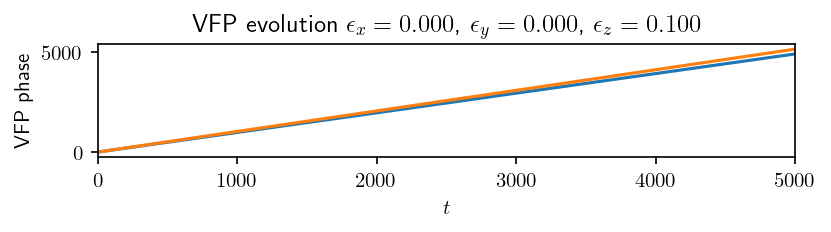

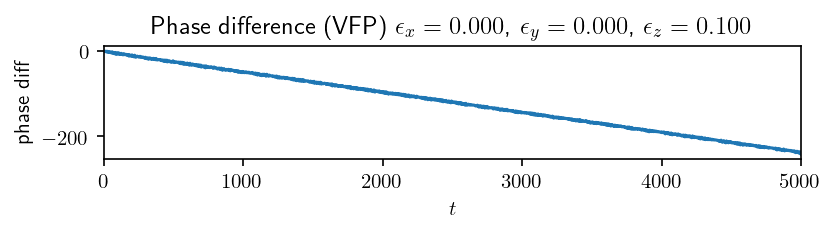

In [21]:
# Plot VFP phase EVOLUTION 
%matplotlib inline

plt_tempo = 0, 5000
plt_att = (T1>plt_tempo[0])&(T1<plt_tempo[1])

fig = plt.figure(figsize=(6,1), dpi=150)
plt.title("VFP evolution $\epsilon_x=%.3f$, $\epsilon_y=%.3f$, $\epsilon_z=%.3f$"%(eps[0], eps[1], eps[2]))
plt.plot(T1, phi_1)
plt.plot(T1, phi_2)
plt.ylabel("VFP phase")
plt.xlabel("$t$")
plt.xlim(plt_tempo)

fig = plt.figure(figsize=(6,1), dpi=150)
plt.title("Phase difference (VFP) $\epsilon_x=%.3f$, $\epsilon_y=%.3f$, $\epsilon_z=%.3f$"%(eps[0], eps[1], eps[2]))
plt.plot(T1, phi_1-phi_2)
plt.ylabel("phase diff")
plt.xlabel("$t$")
plt.xlim(plt_tempo);

############################################################################
# SAVE FIGURE
# plt.savefig('fig/modifiedRossler_z_eps_0_1.pdf', format='pdf', dpi=150)
############################################################################

#### Evaluating synchronization

    MSE: 7.10378


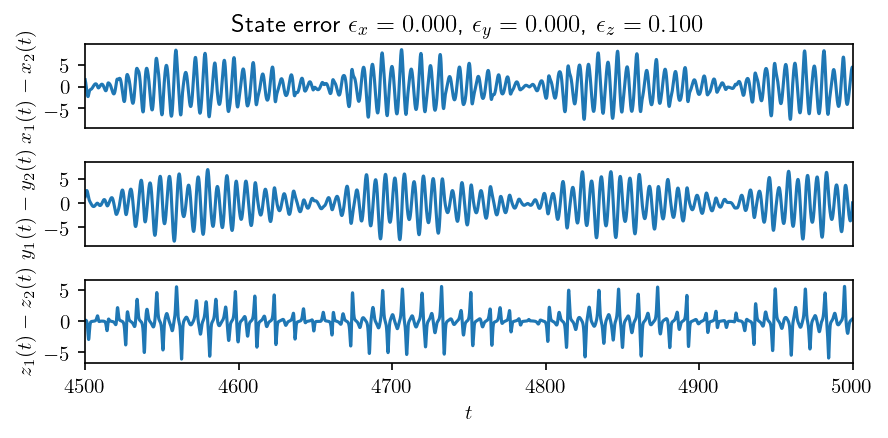

In [22]:
# Plot STATE ERROR (complete synchronization) 
plt_tempo = 4500, 5000
plt_att = (T1>plt_tempo[0])&(T1<plt_tempo[1])

MSE_X1 = np.mean( (X1[:,:3]-X1[:,3:])**2)

print("    MSE: %.5f"%(MSE_X1) ) # MSE (e_z = 0.200) : 6.74526 | MSE (e_z = 0.100) : 7.10378

fig = plt.figure(figsize=(6,3), dpi=150)
plt.subplot(311)
plt.title("State error $\epsilon_x=%.3f$, $\epsilon_y=%.3f$, $\epsilon_z=%.3f$"%(eps[0], eps[1], eps[2]))
plt.plot(T1, X1[:,0]-X1[:,3])
plt.ylabel("$x_1(t)-x_2(t)$")
plt.xlim(plt_tempo)
plt.xticks([])

# fig = plt.figure(figsize=(6,1), dpi=150)
plt.subplot(312)
plt.plot(T1, X1[:,1]-X1[:,4])
plt.ylabel("$y_1(t) - y_2(t)$")
plt.xlim(plt_tempo)
plt.xticks([]);

# fig = plt.figure(figsize=(6,1), dpi=150)
plt.subplot(313)
plt.plot(T1, X1[:,2]-X1[:,5])
plt.ylabel("$z_1(t)-z_2(t)$")
plt.xlim(plt_tempo)
plt.xlabel("$t$")
plt.tight_layout(1);

############################################################################
# SAVE FIGURE
# plt.savefig('fig/modifiedRossler_z_eps_0_1.pdf', format='pdf', dpi=150)
############################################################################

___
## MODIFIED ROSSLER: Simulation of coupled oscillators

In [23]:
# Simulation 
# PARAMETERS
h = .01 #integration step (h=0.001)
tf = 5000 #final time
eps = np.array([0, 0, 0.1]) #coupling strength for each variable
n = 3

# TRANSIENT SIMULATION
np.random.seed(2021)
x0tr = 1*np.random.rand(2*n) #random initial condition
tTr = np.arange(0, 500, h) #transient period (300seg: approx. 50 voltas no atrator)
xTr = intRK2(f_coupRosslerZ, x0tr, tTr, (0*eps,)) #simulate the systems without coupling
xTr = intRK2(f_coupRosslerZ, xTr[-1], tTr, (eps,)) #simulate COUPLED systems

# SIMULATION on permanent regime
T2 = np.arange(0, tf, h) #time range
X2 = intRK2(f_coupRosslerZ, xTr[-1], T2, (eps,)) #use 'intRK' or 'odeint'

In [24]:
# PHASE VARIABLE - compute VFP
timeBetCross_1, crossIdx_1, numPass_1 = f_timeBetCrossPoin(X2[:,:n], T2, f_rossler_poin)
timeBetCross_2, crossIdx_2, numPass_2 = f_timeBetCrossPoin(X2[:,n:], T2, f_rossler_poin)

# Phase variable (Poincaré section)
phi_a_1 = np.interp(T2, T2[crossIdx_1], 2*np.pi*np.arange(len(crossIdx_1)))
phi_a_2 = np.interp(T2, T2[crossIdx_2], 2*np.pi*np.arange(len(crossIdx_2)))

# Phase variable (VFP)
tic = time.time()
phi_1, phi_2, ell1, ell2, freq1, freq2 = f_estimateVFP(X2, T2, crossIdx_1, crossIdx_2,
                                                       lambda x: f_coupRosslerZ(x=x, t=0, eps=eps))
toc = time.time()
print(toc-tic)

3.1678757667541504


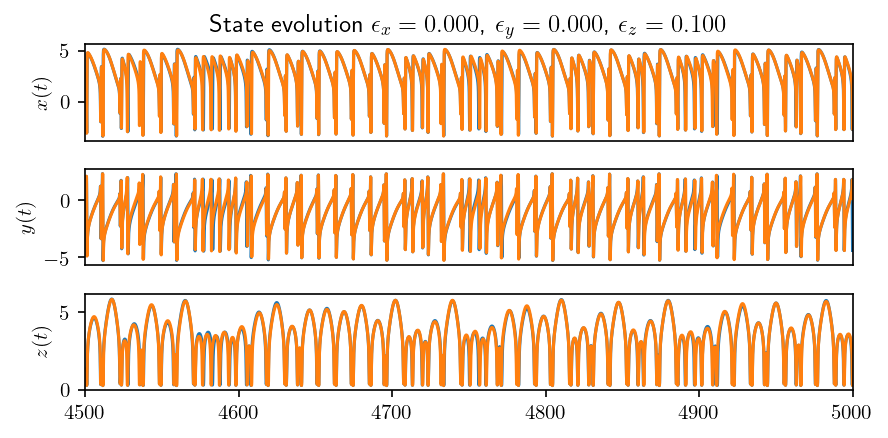

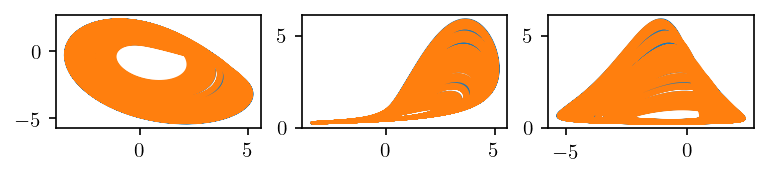

In [25]:
# Plot STATE EVOLUTION 
%matplotlib inline
# %matplotlib widget

X = X2; T = T2;

plt_tempo = 4500, 5000
plt_att = (T>plt_tempo[0])&(T<plt_tempo[1])

fig = plt.figure(figsize=(6,3), dpi=150)
plt.subplot(311)
plt.title("State evolution $\epsilon_x=%.3f$, $\epsilon_y=%.3f$, $\epsilon_z=%.3f$"%(eps[0], eps[1], eps[2]))
plt.plot(T, X[:,0])
plt.plot(T, X[:,3])
plt.ylabel("$x(t)$")
plt.xlim(plt_tempo)
plt.xticks([])

# fig = plt.figure(figsize=(6,1), dpi=150)
plt.subplot(312)
plt.plot(T, X[:,1])
plt.plot(T, X[:,4])
plt.ylabel("$y(t)$")
plt.xlim(plt_tempo)
plt.xticks([])

# fig = plt.figure(figsize=(6,1), dpi=150)
plt.subplot(313)
plt.plot(T, X[:,2])
plt.plot(T, X[:,5])
plt.ylabel("$z(t)$")
plt.xlim(plt_tempo)
plt.tight_layout(1)

############################################################################
# SAVE FIGURE
# plt.savefig('fig/modifiedRossler_z_eps_0_1.pdf', format='pdf', dpi=150)
############################################################################

fig = plt.figure(figsize=(6,1), dpi=150)
plt.subplot(131)
plt.plot(X[plt_att,0], X[plt_att,1])
plt.plot(X[plt_att,3], X[plt_att,4])
plt.subplot(132)
plt.plot(X[plt_att,0], X[plt_att,2])
plt.plot(X[plt_att,3], X[plt_att,5])
plt.subplot(133)
plt.plot(X[plt_att,1], X[plt_att,2])
plt.plot(X[plt_att,4], X[plt_att,5])
plt.show()

# fig = plt.figure(figsize=(3,2), dpi=150)
# plt.axes(projection='3d')
# plt.plot(X[:15000,0], X[:15000,1], X[:15000,2])
# plt.show()



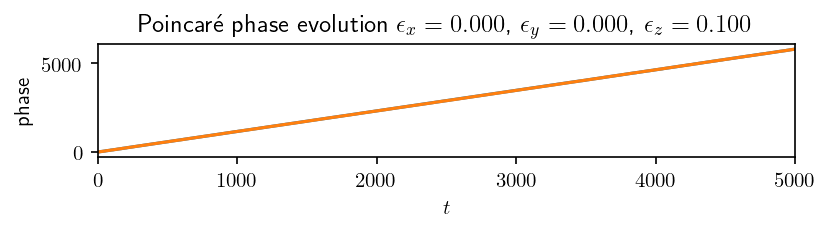

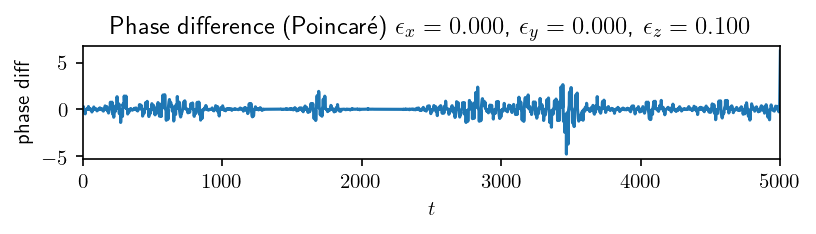

In [26]:
# Plot POINCARE phase EVOLUTION 
%matplotlib inline

T = T2

plt_tempo = 0, 5000
plt_att = (T>plt_tempo[0])&(T<plt_tempo[1])

fig = plt.figure(figsize=(6,1), dpi=150)
plt.title("Poincaré phase evolution $\epsilon_x=%.3f$, $\epsilon_y=%.3f$, $\epsilon_z=%.3f$"%(eps[0], eps[1], eps[2]))
plt.plot(T2, phi_a_1)
plt.plot(T2, phi_a_2)
plt.ylabel("phase")
plt.xlabel("$t$")
plt.xlim(plt_tempo)

fig = plt.figure(figsize=(6,1), dpi=150)
plt.title("Phase difference (Poincaré) $\epsilon_x=%.3f$, $\epsilon_y=%.3f$, $\epsilon_z=%.3f$"%(eps[0], eps[1], eps[2]))
plt.plot(T2, phi_a_1-phi_a_2)
plt.ylabel("phase diff")
plt.xlabel("$t$")
plt.xlim(plt_tempo);

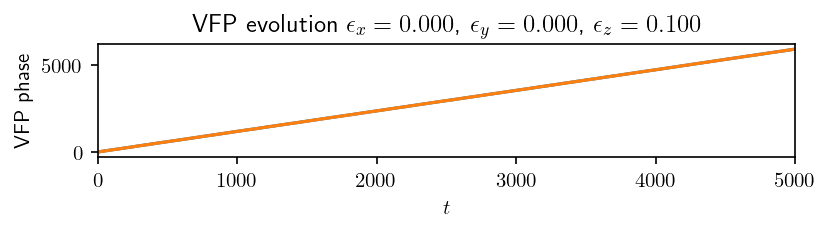

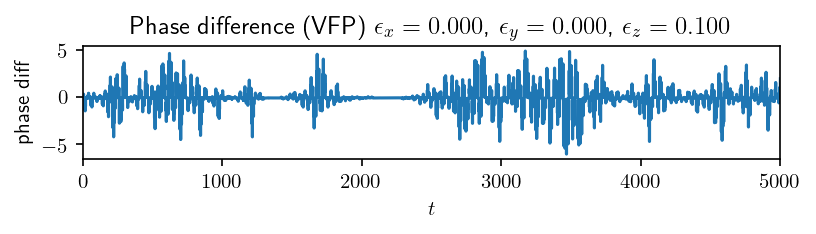

In [27]:
# Plot VFP phase EVOLUTION 
%matplotlib inline

T = T2

plt_tempo = 0, 5000
plt_att = (T>plt_tempo[0])&(T<plt_tempo[1])

fig = plt.figure(figsize=(6,1), dpi=150)
plt.title("VFP evolution $\epsilon_x=%.3f$, $\epsilon_y=%.3f$, $\epsilon_z=%.3f$"%(eps[0], eps[1], eps[2]))
plt.plot(T, phi_1)
plt.plot(T, phi_2)
plt.ylabel("VFP phase")
plt.xlabel("$t$")
plt.xlim(plt_tempo)

fig = plt.figure(figsize=(6,1), dpi=150)
plt.title("Phase difference (VFP) $\epsilon_x=%.3f$, $\epsilon_y=%.3f$, $\epsilon_z=%.3f$"%(eps[0], eps[1], eps[2]))
plt.plot(T, phi_1-phi_2)
plt.ylabel("phase diff")
plt.xlabel("$t$")
plt.xlim(plt_tempo);

############################################################################
# SAVE FIGURE
# plt.savefig('fig/modifiedRossler_z_eps_0_1.pdf', format='pdf', dpi=150)
############################################################################

    MSE: 0.47621


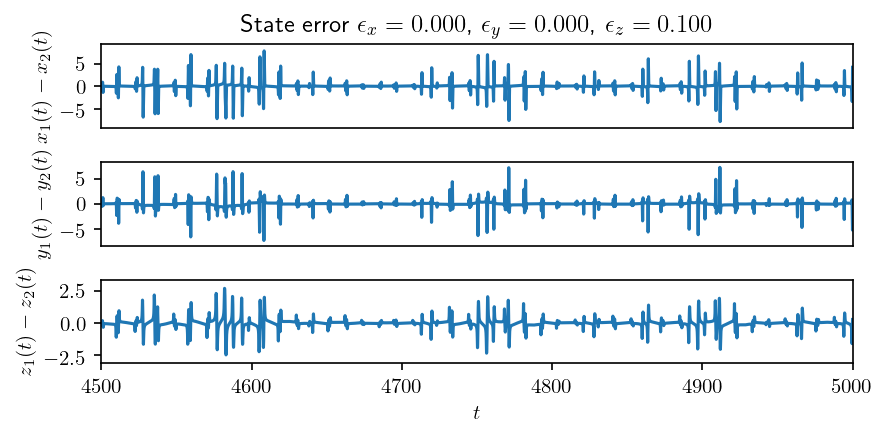

In [28]:
# Plot STATE ERROR (MSE_x: 2.76386, MSE_y: 4.14488, MSE_z: 0.47621) 
plt_tempo = 4500, 5000
plt_att = (T>plt_tempo[0])&(T<plt_tempo[1])

MSE_X2 = np.mean( (X2[:,:3]-X2[:,3:])**2)

print("    MSE: %.5f"%(MSE_X2) ) # MSE (e_z = 0.100) : 0.47621

fig = plt.figure(figsize=(6,3), dpi=150)
plt.subplot(311)
plt.title("State error $\epsilon_x=%.3f$, $\epsilon_y=%.3f$, $\epsilon_z=%.3f$"%(eps[0], eps[1], eps[2]))
plt.plot(T, X[:,0]-X[:,3])
plt.ylabel("$x_1(t)-x_2(t)$")
plt.xlim(plt_tempo)
plt.xticks([])

# fig = plt.figure(figsize=(6,1), dpi=150)
plt.subplot(312)
plt.plot(T, X[:,1]-X[:,4])
plt.ylabel("$y_1(t) - y_2(t)$")
plt.xlim(plt_tempo)
plt.xticks([]);

# fig = plt.figure(figsize=(6,1), dpi=150)
plt.subplot(313)
plt.plot(T, X[:,2]-X[:,5])
plt.ylabel("$z_1(t)-z_2(t)$")
plt.xlim(plt_tempo)
plt.xlabel("$t$")
plt.tight_layout(1);

############################################################################
# SAVE FIGURE
# plt.savefig('fig/modifiedRossler_z_eps_0_1.pdf', format='pdf', dpi=150)
############################################################################

# Phase information index

For an oscillator, we consider the VFP, denoted by $\phi(t)$, as the phase, the "gold standard" of the phase evolution. However, the VFP is not easy to compute, due to the length $\ell$. Many works define an ad hoc phase definition as

\begin{equation}
  \varphi(t) = h(\boldsymbol{x}(t)),
\end{equation}

that is an approximation of the phase of the system, that will be called a phaselike variable.

In a general case, we can compute the amount of phase information that is present in an observer $h(x)$. Based on VFP, the instantaneous phase information could be computed as the inner product between the two variables as

\begin{equation}
  \langle h(\boldsymbol{x}(t)), \phi(t) \rangle = \int h(\boldsymbol{x}(t)) \phi(t) dt .
\end{equation}

However, this equation is hard to implement and the arbitrary initial phase can embarrass the result. Instead, we propose an alternative as follows. 

One of the main contribution of the VFP is the insight that the gradient of the phase variable points to the direction of the vector field, in the whole state space. That is, the direction of the fastest increase of the VFP is the direction of $f(x)$. Based on this definition, is possible to measure the projection of the vector field on $\nabla h(x)$. The instantaneous phase information index can be computed as

\begin{equation}
  \iota(t) = \frac{ \lVert \langle \nabla h(\boldsymbol{x}(t)), f(\boldsymbol{x}(t)) \rangle \rVert }{\lVert \nabla h(\boldsymbol{x}(t)) \rVert \, \lVert f(\boldsymbol{x}(t)) \rVert},
\end{equation}

that is the normalized norm of the inner product. When $\nabla h(\boldsymbol{x}(t))$ is colinear to $f(\boldsymbol{x}(t))$ then $\iota(t)=1$, representing that the observer contains all information about the rhythm of the oscillation. When $\iota(t) = 0$, the observer have no phase information.

**Remark**: by definition, the VFP has $\iota(t)=1, \forall t$.

For a trajectory $\gamma(t;x_0)$ from an initial condition $x_0$ and with time duration $T$, the average phase information can be computed as 

\begin{equation}
  \bar{\iota}_{(T; x_0)} = \frac{1}{T} \int_{T} \frac{ \lVert \langle \nabla h(\boldsymbol{x}(t)), f(\boldsymbol{x}(t)) \rangle \rVert }{\lVert \nabla h(\boldsymbol{x}(t)) \rVert \, \lVert f(\boldsymbol{x}(t)) \rVert} dt,
\end{equation}

and a numerical approximation is given by

\begin{equation}
  \hat{\bar{\iota}}_{(T; x_0)} = \frac{1}{N} \sum_{n=0}^{N-1} \frac{ \lVert \langle \nabla h(x(n\Delta_t)), f(x(n\Delta_t)) \rangle \rVert }{\lVert \nabla h(x(n\Delta_t)) \rVert \, \lVert f(x(n\Delta_t)) \rVert} ,  
\end{equation}

where $N$ is the number of points, $\Delta_t$ is the sampling period.



In [30]:
def f_phaseInfo(dh, fx):
    """
    Compute the phase information of an observer.
    
    Input
     - dh: gradient of the observer h(x), dh.shpae = (order, )
     - fx: vector field computed in all points, fx.shape = (order, #of points)
     
    Output
     - phaseInfo_avg: averaged phase information
     - phaseInfo: phase information computed for each sample
    """
    n, N = fx.shape
    dh = dh.reshape(n, 1)
    phaseInfo = np.linalg.norm(np.dot(dh.T, fx), axis=0)/(np.linalg.norm(dh, axis=0)*np.linalg.norm(fx, axis=0))
    phaseInfo_avg = np.mean(phaseInfo)
    return phaseInfo_avg, phaseInfo

## Numerical Results

For the oscillators, let assume the observers

\begin{align}
  h_x (t) &= x(t),  \\ h_y (t) &= y(t), \\ h_z (t) &= z(t).
\end{align}

The results are shown below.

### Classical Rossler

Note that the "classical" Rossler oscillator have 

\begin{equation}
    x \triangleright y \triangleright z.
\end{equation}

In [31]:
# Simulation 
# PARAMETERS
h = .01 #integration step (h=0.001)
tf = 5000 #final time
n = 3 #system order
omg = 1; a = .398; b = 2; c = 4 #parameters

# TRANSIENT SIMULATION
np.random.seed(1986)
x0tr = 1*np.random.rand(n) #random initial condition
tTr = np.arange(0, 500, h) #transient period (300seg: approx. 50 voltas no atrator)
xTr = intRK2(f_rossler, x0tr, tTr, (omg, a, b, c)) #simulate the systems without coupling
xTr = intRK2(f_rossler, xTr[-1], tTr, (omg, a, b, c)) #simulate COUPLED systems

# SIMULATION on permanent regime
T3 = np.arange(0, tf, h) #time range
X3 = intRK2(f_rossler, xTr[-1], T3, (omg, a, b, c)) #use 'intRK' or 'odeint'

In [32]:
# PHASE VARIABLE - compute VFP
timeBetCross_X3, crossIdx_X3, numPass_X3 = f_timeBetCrossPoin(X3[:,:n], T3, f_rossler_poin)

# Phase variable (Poincaré section)
phi_a_1_X3 = np.interp(T3, T3[crossIdx_X3], 2*np.pi*np.arange(len(crossIdx_X3)))

# Phase variable (VFP)
tic = time.time()
phi_1_X3, ell1_X3, freq1_X3 = f_estimateVFP_1(X3, T3, crossIdx_X3,
                                              lambda x: f_rossler(x=x, t=0, omg=omg, a=a, b=b, c=c))
toc = time.time()
print(toc-tic)

2.104139566421509


In [33]:
# Phase information about the 

# Gradient computation of the observers
grad_hx = np.array([1,0,0]).reshape(3,1)
grad_hy = np.array([0,1,0]).reshape(3,1)
grad_hz = np.array([0,0,1]).reshape(3,1)

#########################################
# PHASE INFORMATION
# Trajectory used to compute phase information
X = X3

odeFun = lambda x: f_rossler(x , 0, omg=omg, a=a, b=b, c=c)

# Vector field calculation
N, n = X.shape
f_X3 = np.empty_like(X)
for k in range(N):
    f_X3[k,:] = odeFun(X[k,:]) #using a "for loop" because "f_ode" is not vectorized...

# Phase information
phInfo_X3_x_avg, phInfo_X3_x = f_phaseInfo(grad_hx, f_X3.T)
phInfo_X3_y_avg, phInfo_X3_y = f_phaseInfo(grad_hy, f_X3.T)
phInfo_X3_z_avg, phInfo_X3_z = f_phaseInfo(grad_hz, f_X3.T)

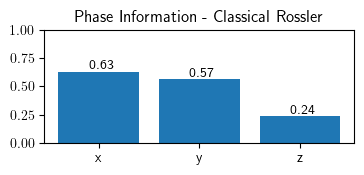

In [34]:
# Phase information 
# The sum of the phase information indexes 

plt.figure(figsize=(4,1.5), dpi=100)
plt.bar([1,2,3], [phInfo_X3_x_avg, phInfo_X3_y_avg, phInfo_X3_z_avg])
plt.xticks([1,2,3], ("x","y","z"));
plt.ylim(0,1)
plt.title("Phase Information - Classical Rossler");
plt.text(1-.1, phInfo_X3_x_avg+.02, "%.2f"%phInfo_X3_x_avg)
plt.text(2-.1, phInfo_X3_y_avg+.02, "%.2f"%phInfo_X3_y_avg)
plt.text(3-.1, phInfo_X3_z_avg+.02, "%.2f"%phInfo_X3_z_avg);

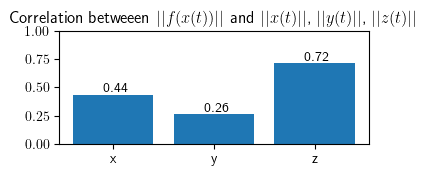

In [142]:
# X3: correlation betweeen ||f(x)|| and ||x(t)||, ||y(t)||, ||z(t)||
from scipy import stats

f_X3_norm = np.linalg.norm(f_X3, axis=1)
X3_x_norm = np.linalg.norm(X3[:,0:1], axis=1)
X3_y_norm = np.linalg.norm(X3[:,1:2], axis=1)
X3_z_norm = np.linalg.norm(X3[:,2:3], axis=1)

corr_x_r, corr_x_p = sp.stats.pearsonr(f_X3_norm, X3_x_norm)
corr_y_r, corr_y_p = sp.stats.pearsonr(f_X3_norm, X3_y_norm)
corr_z_r, corr_z_p = sp.stats.pearsonr(f_X3_norm, X3_z_norm)

plt.figure(figsize=(4,1.5), dpi=100)
plt.bar([1,2,3], [corr_x_r, corr_y_r, corr_z_r])
plt.xticks([1,2,3], ("x","y","z"));
plt.ylim(0,1)
plt.title("Correlation betweeen $||f(x(t))||$ and $||x(t)||$, $||y(t)||$, $||z(t)||$");
plt.text(1-.1, corr_x_r+.02, "%.2f"%corr_x_r)
plt.text(2-.1, corr_y_r+.02, "%.2f"%corr_y_r)
plt.text(3-.1, corr_z_r+.02, "%.2f"%corr_z_r);

Phase information of x(t)


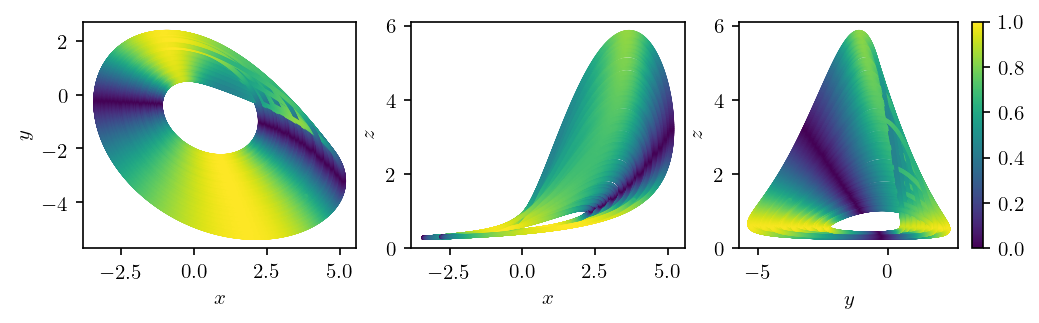

Phase information of y(t)


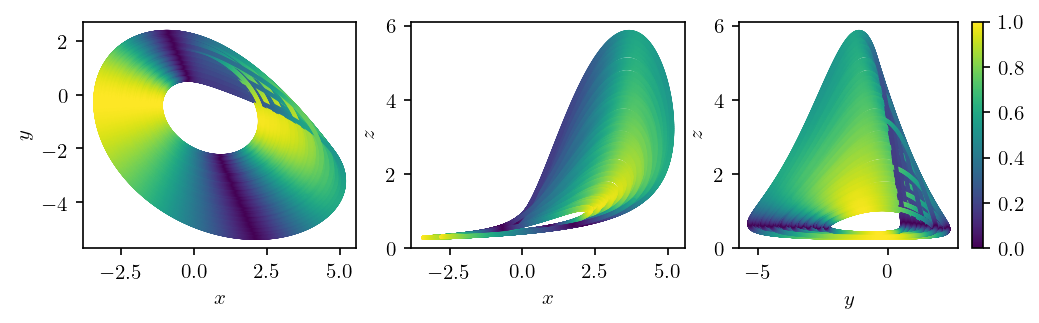

Phase information of z(t)


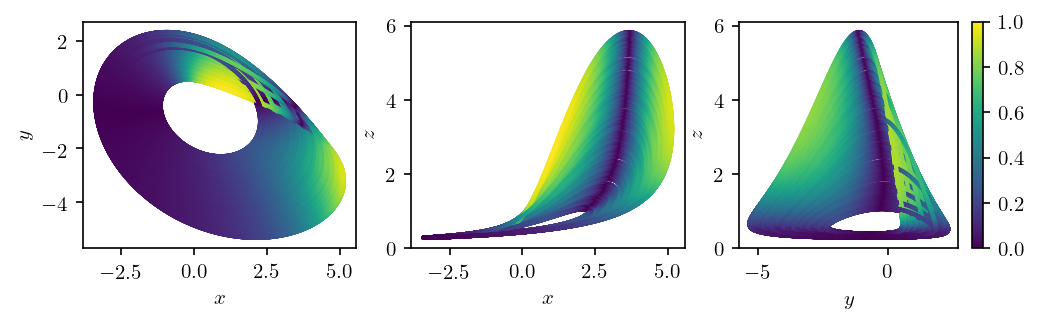

In [161]:
# Plot STATE EVOLUTION 
%matplotlib inline
# %matplotlib widget

X = X3; T = T3; phaseInfo = phInfo_X3_z

plt_tempo = 0, 1027
plt_att = (T>plt_tempo[0])&(T<plt_tempo[1])

############################################################################
# SAVE FIGURE
# plt.savefig('fig/modifiedRossler_z_eps_0_1.pdf', format='pdf', dpi=150)
############################################################################

print("Phase information of x(t)")
fig = plt.figure(figsize=(8,2), dpi=150)
plt.subplot(131)
plt.scatter(X[plt_att,0], X[plt_att,1], c = phInfo_X3_x[plt_att], s=1)
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.subplot(132)
plt.scatter(X[plt_att,0], X[plt_att,2], c = phInfo_X3_x[plt_att], s=1)
plt.xlabel("$x$"); plt.ylabel("$z$")
plt.subplot(133)
plt.scatter(X[plt_att,1], X[plt_att,2], c = phInfo_X3_x[plt_att], s=1)
plt.xlabel("$y$"); plt.ylabel("$z$")
plt.colorbar(); plt.clim(0, 1)
plt.show()

print("Phase information of y(t)")
fig = plt.figure(figsize=(8,2), dpi=150)
plt.subplot(131)
plt.scatter(X[plt_att,0], X[plt_att,1], c = phInfo_X3_y[plt_att], s=1)
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.subplot(132)
plt.scatter(X[plt_att,0], X[plt_att,2], c = phInfo_X3_y[plt_att], s=1)
plt.xlabel("$x$"); plt.ylabel("$z$")
plt.subplot(133)
plt.scatter(X[plt_att,1], X[plt_att,2], c = phInfo_X3_y[plt_att], s=1)
plt.xlabel("$y$"); plt.ylabel("$z$")
plt.colorbar(); plt.clim(0, 1)
plt.show()

print("Phase information of z(t)")
fig = plt.figure(figsize=(8,2), dpi=150)
plt.subplot(131)
plt.scatter(X[plt_att,0], X[plt_att,1], c = phInfo_X3_z[plt_att], s=1)
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.subplot(132)
plt.scatter(X[plt_att,0], X[plt_att,2], c = phInfo_X3_z[plt_att], s=1)
plt.xlabel("$x$"); plt.ylabel("$z$")
plt.subplot(133)
plt.scatter(X[plt_att,1], X[plt_att,2], c = phInfo_X3_z[plt_att], s=1)
plt.xlabel("$y$"); plt.ylabel("$z$")
plt.colorbar(); plt.clim(0, 1)
plt.show()

### Modified Rossler

The modified Rossler oscillator have MEASURE 

\begin{equation}
    y \approx x \approx z.
\end{equation}

But we expect

\begin{equation}
    z \triangleright y \approx x.
\end{equation}

In [35]:
# Simulation 
# PARAMETERS
h = .01 #integration step (h=0.001)
tf = 5000 #final time
n = 3 #system order
omg = 1; a = .398; b = 2; c = 4 #parameters

# TRANSIENT SIMULATION
np.random.seed(1986)
x0tr = 1*np.random.rand(n) #random initial condition
tTr = np.arange(0, 500, h) #transient period (300seg: approx. 50 voltas no atrator)
xTr = intRK2(f_rosslerZ, x0tr, tTr, (omg, a, b, c)) #simulate the systems without coupling
xTr = intRK2(f_rosslerZ, xTr[-1], tTr, (omg, a, b, c)) #simulate COUPLED systems

# SIMULATION on permanent regime
T4 = np.arange(0, tf, h) #time range
X4 = intRK2(f_rosslerZ, xTr[-1], T4, (omg, a, b, c)) #use 'intRK' or 'odeint'

In [36]:
# PHASE VARIABLE - compute VFP
timeBetCross_X4, crossIdx_X4, numPass_X4 = f_timeBetCrossPoin(X4[:,:n], T4, f_rossler_poin)

# Phase variable (Poincaré section)
phi_a_1_X4 = np.interp(T4, T4[crossIdx_X4], 2*np.pi*np.arange(len(crossIdx_X4)))

# Phase variable (VFP)
tic = time.time()
phi_1_X4, ell1_X4, freq1_X4 = f_estimateVFP_1(X4, T4, crossIdx_X4,
                                              lambda x: f_rossler(x=x, t=0, omg=omg, a=a, b=b, c=c))
toc = time.time()
print(toc-tic)

2.0577943325042725


In [37]:
# Phase information about the 

# Gradient computation of the observers
grad_hx = np.array([1,0,0]).reshape(3,1)
grad_hy = np.array([0,1,0]).reshape(3,1)
grad_hz = np.array([0,0,1]).reshape(3,1)

#########################################
# PHASE INFORMATION
# Trajectory used to compute phase information
X = X4

odeFun = lambda x: f_rosslerZ(x, 0, omg=omg, a=a, b=b, c=c)

# Vector field calculation
N, n = X.shape
f_X4 = np.empty_like(X)
for k in range(N):
    f_X4[k,:] = odeFun(X[k,:]) #using a "for loop" because "f_ode" is not vectorized...

# Phase information
phInfo_X4_x_avg, phInfo_X4_x = f_phaseInfo(grad_hx, f_X4.T)
phInfo_X4_y_avg, phInfo_X4_y = f_phaseInfo(grad_hy, f_X4.T)
phInfo_X4_z_avg, phInfo_X4_z = f_phaseInfo(grad_hz, f_X4.T)

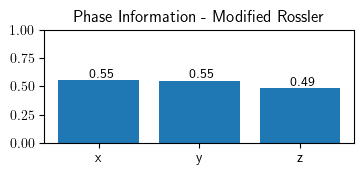

In [38]:
# Phase information 
# The sum of the phase information indexes 

plt.figure(figsize=(4,1.5), dpi=100)
plt.bar([1,2,3], [phInfo_X4_x_avg, phInfo_X4_y_avg, phInfo_X4_z_avg])
plt.xticks([1,2,3], ("x","y","z"));
plt.ylim(0,1)
plt.title("Phase Information - Modified Rossler");
plt.text(1-.1, phInfo_X4_x_avg+.02, "%.2f"%phInfo_X4_x_avg)
plt.text(2-.1, phInfo_X4_y_avg+.02, "%.2f"%phInfo_X4_y_avg)
plt.text(3-.1, phInfo_X4_z_avg+.02, "%.2f"%phInfo_X4_z_avg);

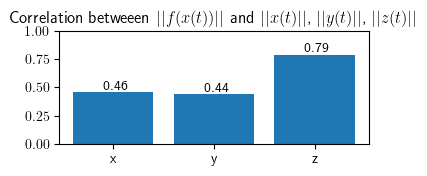

In [149]:
# X4: absolute correlation betweeen ||f(x)|| and ||x(t)||, ||y(t)||, ||z(t)||
from scipy import stats

f_X4_norm = np.linalg.norm(f_X4, axis=1)
X4_x_norm = np.linalg.norm(X4[:,0:1], axis=1)
X4_y_norm = np.linalg.norm(X4[:,1:2], axis=1)
X4_z_norm = np.linalg.norm(X4[:,2:3], axis=1)

corr_x_r, corr_x_p = sp.stats.pearsonr(f_X4_norm, X4_x_norm)
corr_y_r, corr_y_p = sp.stats.pearsonr(f_X4_norm, X4_y_norm)
corr_z_r, corr_z_p = sp.stats.pearsonr(f_X4_norm, X4_z_norm)

# ABSOLITE VALUE OF CORRELATION (negative or positive)
corr_x_r, corr_y_r, corr_z_r = np.abs((corr_x_r, corr_y_r, corr_z_r))

plt.figure(figsize=(4,1.5), dpi=100)
plt.bar([1,2,3], [corr_x_r, corr_y_r, corr_z_r])
plt.xticks([1,2,3], ("x","y","z"));
plt.ylim(0,1)
plt.title("Correlation betweeen $||f(x(t))||$ and $||x(t)||$, $||y(t)||$, $||z(t)||$");
plt.text(1-.1, corr_x_r+.02, "%.2f"%corr_x_r)
plt.text(2-.1, corr_y_r+.02, "%.2f"%corr_y_r)
plt.text(3-.1, corr_z_r+.02, "%.2f"%corr_z_r);

Phase information of x(t)


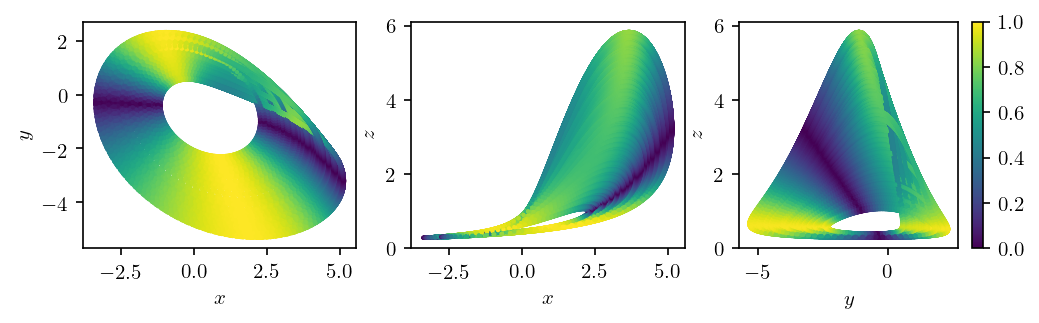

Phase information of y(t)


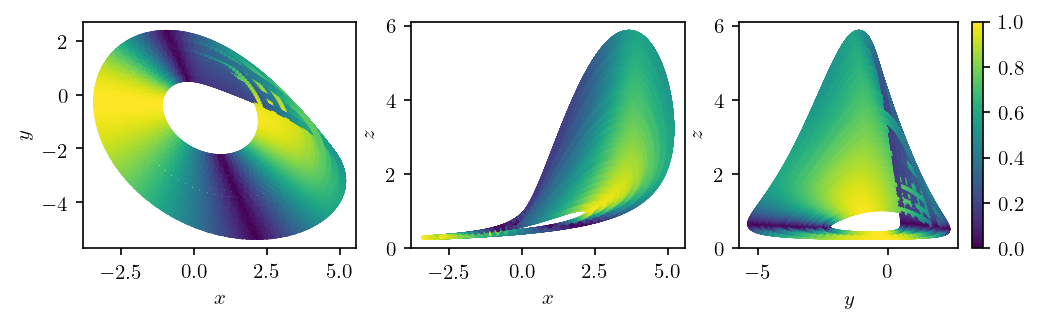

Phase information of z(t)


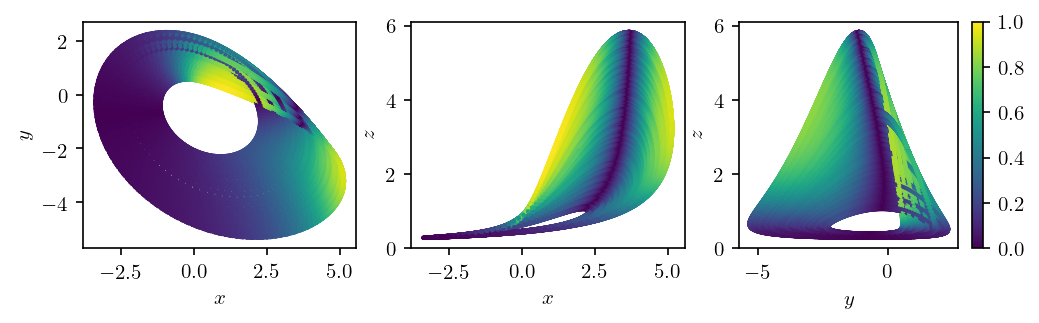

In [162]:
# Plot STATE EVOLUTION 
%matplotlib inline
# %matplotlib widget

X = X4; T = T4; phaseInfo = phInfo_X4_z

plt_tempo = 0, 2027
plt_att = (T>plt_tempo[0])&(T<plt_tempo[1])

############################################################################
# SAVE FIGURE
# plt.savefig('fig/modifiedRossler_z_eps_0_1.pdf', format='pdf', dpi=150)
############################################################################

print("Phase information of x(t)")
fig = plt.figure(figsize=(8,2), dpi=150)
plt.subplot(131)
plt.scatter(X[plt_att,0], X[plt_att,1], c = phInfo_X4_x[plt_att], s=1)
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.subplot(132)
plt.scatter(X[plt_att,0], X[plt_att,2], c = phInfo_X4_x[plt_att], s=1)
plt.xlabel("$x$"); plt.ylabel("$z$")
plt.subplot(133)
plt.scatter(X[plt_att,1], X[plt_att,2], c = phInfo_X4_x[plt_att], s=1)
plt.xlabel("$y$"); plt.ylabel("$z$")
plt.colorbar(); plt.clim(0, 1)
plt.show()

print("Phase information of y(t)")
fig = plt.figure(figsize=(8,2), dpi=150)
plt.subplot(131)
plt.scatter(X[plt_att,0], X[plt_att,1], c = phInfo_X4_y[plt_att], s=1)
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.subplot(132)
plt.scatter(X[plt_att,0], X[plt_att,2], c = phInfo_X4_y[plt_att], s=1)
plt.xlabel("$x$"); plt.ylabel("$z$")
plt.subplot(133)
plt.scatter(X[plt_att,1], X[plt_att,2], c = phInfo_X4_y[plt_att], s=1)
plt.xlabel("$y$"); plt.ylabel("$z$")
plt.colorbar(); plt.clim(0, 1)
plt.show()

print("Phase information of z(t)")
fig = plt.figure(figsize=(8,2), dpi=150)
plt.subplot(131)
plt.scatter(X[plt_att,0], X[plt_att,1], c = phInfo_X4_z[plt_att], s=1)
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.subplot(132)
plt.scatter(X[plt_att,0], X[plt_att,2], c = phInfo_X4_z[plt_att], s=1)
plt.xlabel("$x$"); plt.ylabel("$z$")
plt.subplot(133)
plt.scatter(X[plt_att,1], X[plt_att,2], c = phInfo_X4_z[plt_att], s=1)
plt.xlabel("$y$"); plt.ylabel("$z$")
plt.colorbar(); plt.clim(0, 1)
plt.show()

___
The end

Tentando outras medidas... mas DERAM ERRADO!

In [358]:
# outras medidas...
X = X4
fx = f_X4

fx_norm = np.linalg.norm(fx, axis=1)

##################################################################################
# 1. Correlation between h(x) and the norm of f(x)

h_x = X[:,0]
med_x = np.sum(fx_norm*h_x) / ( np.linalg.norm(fx_norm)*np.linalg.norm(h_x) )
h_x = X[:,1]
med_y = np.sum(fx_norm*h_x) / ( np.linalg.norm(fx_norm)*np.linalg.norm(h_x) )
h_x = X[:,2]
med_z = np.sum(fx_norm*h_x) / ( np.linalg.norm(fx_norm)*np.linalg.norm(h_x) )

print(med_x, med_y, med_z)

##################################################################################
# 2. Correlation between dh/dt and dphi/dt

corr = lambda x1, x2: np.abs(np.mean(x1*x2)) / ( np.var(x1)*np.var(x2) )

dhdt = fx[:,0]
fx_norm = np.linalg.norm(fx, axis=1)
dphidt = fx_norm #the term 2pi is a constant and the ell was approximated as a constant
dphidt = dphidt-np.mean(dphidt)
dhdt = dhdt-np.mean(dhdt)
me2_x = corr(dhdt, dphidt)

dhdt = fx[:,1]
fx_norm = np.linalg.norm(fx, axis=1)
dphidt = fx_norm #the term 2pi is a constant and the ell was approximated as a constant
dphidt = dphidt-np.mean(dphidt)
dhdt = dhdt-np.mean(dhdt)
me2_y = corr(dhdt, dphidt)

dhdt = fx[:,2]
fx_norm = np.linalg.norm(fx, axis=1)
dphidt = fx_norm #the term 2pi is a constant and the ell was approximated as a constant
dphidt = dphidt-np.mean(dphidt)
dhdt = dhdt-np.mean(dhdt)
me2_z = corr(dhdt, dphidt)

print(me2_x, me2_y, me2_z)

# n, N = fx.shape
# dh = dh.reshape(n, 1)
# phaseInfo = np.linalg.norm(np.dot(dh.T, fx), axis=0)/(np.linalg.norm(dh, axis=0)*np.linalg.norm(fx, axis=0))
# phaseInfo_avg = np.mean(phaseInfo)
# return phaseInfo_avg, phaseInfo

0.1199531454083153 -0.3925065818074538 0.1721207118349474
0.009401114318362621 0.014436471237158187 0.004552011884277114


#### Coupled Hiperchaotic Rossler

In [ ]:
# Simulation 
# PARAMETERS
h = .01 #integration step (h=0.001)
tf = 10000 #final time | x0 = −10; y0 = −6; z0 = 0; w0 = 10.0;
eps = .00001
n = 4

# TRANSIENT SIMULATION
x0tr = 1*np.random.rand(2*n) + (-10,-6,0,10,-10,-6,0,10) #random initial condition
tTr = np.arange(0, 500, h) #transient period (300seg: approx. 50 voltas no atrator)
xTr = intRK2(f_hyperChaosRossler_sync, x0tr, tTr, (0,)) #simulate the systems without coupling
xTr = intRK2(f_hyperChaosRossler_sync, xTr[-1], tTr, (eps,)) #simulate COUPLED systems

# SIMULATION on permanent regime
T1 = np.arange(0, tf, h) #time range
X1 = intRK2(f_hyperChaosRossler_sync, xTr[-1], T1, (eps,)) #use 'intRK' or 'odeint'

#### Rossler

In [ ]:
# Rossler (spiral)

# PARAMETERS
h = .001 #integration step (h=0.001)
tf = 20000 #final time

# TRANSIENT SIMULATION
x0tr = np.random.rand(3) #random initial condition
tTr = np.arange(0, 2*tf, h) #transient period (300seg: approx. 50 voltas no atrator)
xTr = intRK2(f_rossler, x0tr, tTr, (1., .16, .1, 8.5)) #use 'intRK' or 'odeint'

# SIMULATION on permanent regime
T1 = np.arange(0, tf, h) #time range
X1 = intRK2(f_rossler, xTr[-1], T1, (1., .16, .1, 8.5))

# FIM...
(códigos de exemplo para ajudar a fazer gráficos e outras coisas)

In [ ]:
# PLOT: attractor, section and returning time
fig1 = plt.figure(figsize=(2.5,2.5), dpi=100)

# Fit Gaussian distribution
muT = np.mean(timeBetCross[timeBetCross<100])
stdT = np.std(timeBetCross[timeBetCross<100])

muT2 = np.mean(timeBetCross[timeBetCross>100])
stdT2 = np.std(timeBetCross[timeBetCross>100])


ax1 = fig1.add_subplot(111)
n, bins, patches = ax1.hist(timeBetCross, bins=20, facecolor=(1,0.7,0.0,1), normed=1) #bins='auto'

# Gaussian plot: 1st time scale
gaussPlot_x = np.linspace(0, 130, 100)
gaussPlot = np.exp(-np.power(gaussPlot_x - muT, 2.) / (2 * np.power(stdT, 2.)))
ax1.plot(gaussPlot_x, .04*gaussPlot, '-', c=(0.8,0.6,.2,1), lw=3)

# Gaussian plot: 2st time scale
gaussPlot_x = np.linspace(130, 250, 100)
gaussPlot = np.exp(-np.power(gaussPlot_x - muT2, 2.) / (2 * np.power(stdT2, 2.)))
ax1.plot(gaussPlot_x, .006*gaussPlot, '-', c=(0.8,0.6,.2,1), lw=3)

ax1.set_xlabel('$t_k-t_{k-1}$')
ax1.set_ylim((0,.05)); ax1.set_xlim((0,250))
ax1.grid(False)
ax1.set_yticks([])

ax1.text(50, .013, '$\mu_1=%.1f$\n $\sigma_1=%.1f$'%(muT,stdT), fontsize=12, color=(0.1,0.1,0.1,1))
ax1.text(115, .001, '$\mu_2=%.1f$\n $\sigma_2=%.1f$'%(muT2,stdT2), fontsize=12, color=(0.1,0.1,0.1,1))

ax2 = fig1.add_axes([0.52, 0.53, 0.35, 0.33]) #[left, bottom, width, height] unitless percentages
ax2.plot(Xp[1050:8000,0], Xp[1050:8000,1], '-', c=(0.,0.0,0.5,1), lw=.5)
ax2.plot([0,0], [-1,1.8], '-', c=(.7,0.4,0,1), lw=2)
ax2.text(.15, -3, '$\mathcal{P}_1$', fontsize=10, color=(0.2,0.2,0.2,1))
ax2.set_xlabel('$x$'); ax2.set_ylabel('$y$')
ax2.grid(False); ax2.set_xticks([]); ax2.set_yticks([])

# plt.savefig('fig/hindmarshRose_returnTime_attractor_1c.eps', format='eps', dpi=150)
plt.show()

In [ ]:
# PLOT: attractor, section and returning time
fig1 = plt.figure(figsize=(2.5,2.5), dpi=100)

# Fit Gaussian distribution
muT3 = np.mean(timeBetCross2)
stdT3 = np.std(timeBetCross2)

ax1 = fig1.add_subplot(111)

# Gaussian plot: 3st time scale
gaussPlot_x = np.linspace(600, 1500, 100)
gaussPlot = np.exp(-np.power(gaussPlot_x - muT3, 2.) / (2 * np.power(stdT3, 2.)))
ax1.plot(gaussPlot_x, .01*gaussPlot, '-', c=(0.4,0.7,0.4,1), lw=3)

n, bins, patches = ax1.hist(timeBetCross2, bins=8, facecolor=(0.4,.8,0.,1), normed=1) #bins='auto'

ax1.set_xlabel('$t_k-t_{k-1}$')
ax1.set_ylim((0,.011)); ax1.set_xlim((600,1400))
ax1.grid(False)
ax1.set_yticks([])

ax1.text(990, .0005, '$\mu=%.2f$\n$\sigma=%.2f$'%(muT3,stdT3), fontsize=12, color=(0.1,0.1,0.1,1))

ax2 = fig1.add_axes([0.50, 0.5, 0.37, 0.36]) #[left, bottom, width, height] unitless percentages
ax2.plot(Xp[1050:8000,1], Xp[1050:8000,2], '-', c=(0.,0.0,0.5,1), lw=.5)
ax2.plot([-10.5,-8.6], [2,2], '-', c=(0.1,.4,0.,1), lw=2)
ax2.text(-8.8, 1.93, '$\mathcal{P}_2$', fontsize=10, color=(0.2,0.2,0.2,1))
ax2.set_xlabel('$y$'); ax2.set_ylabel('$z$')
ax2.grid(False); ax2.set_xticks([]); ax2.set_yticks([])

# plt.savefig('fig/hindmarshRose_returnTime_attractor_2c.eps', format='eps', dpi=150)
plt.show()

In [ ]:
# PLOT: attractor, section and returning time
fig1 = plt.figure(figsize=(5.2,1), dpi=100)

ax1 = fig1.add_subplot(111)
ax1.plot(Tp[2850:28000]-285,Xp[2850:28000,0], '-', c=(0.0,0.0,0.3,1), lw=1)
ax1.plot(Tp[crossIdx]-285,Xp[crossIdx,0], 's', c=(1,0.7,0.0,1), ms=3)
ax1.plot(Tp[crossIdx2]-285,Xp[crossIdx2,0], 'd', c=(0.4,.8,0.,1), ms=5)
ax1.set_yticks([])

ax1.text(890, 0.4, '$\mathcal{P}_1$', fontsize=10, color=(0.0,0.0,0.0,1))
ax1.plot([810,880],[0.2,0.6], '-', c=(0.3,0.3,0.3,1), lw=1)

ax1.text(1560, -.15, '$\mathcal{P}_2$', fontsize=10, color=(0.0,0.0,0.0,1))
ax1.plot([1540,1575],[-1.1,-0.2], '-', c=(0.3,0.3,0.3,1), lw=1)

# ax1.set_xlabel('$t$');
ax1.set_ylabel('$x$')
ax1.set_xlim((0,1650)); ax1.set_ylim((-2,2.2))
ax1.grid(False)

# plt.savefig('fig/hindmarshRose_PoinSec_x.eps', format='eps', dpi=150)
plt.show()

In [ ]:
# Time evolution of the state variables

# ----------------------------------------------------------------------
# INTERACTIVE plot!
import plotly.offline as py
import plotly.graph_objs as go

py.init_notebook_mode(connected=True) #initialize on notebook

# Create traces
trace0 = go.Scatter( x = Tp[:70], y = Xp[:70,0], mode = 'lines', name = 'x' )
# trace1 = go.Scatter( x = Tp, y = Xp[:,1], mode = 'lines', name = 'y' )
# trace2 = go.Scatter( x = Tp, y = Xp[:,2], mode = 'lines', name = 'z' )
data = [trace0, trace1, trace2]

py.iplot(data, filename='line-mode')

In [ ]:
# PLOT: length vs state variable (static)
fig1 = plt.figure(figsize=(8,4), dpi=100)

# ax1 = fig1.add_subplot(121)
# ax1.plot(Xp[crossIdx[1:],1], timeBetCross, '.', c=(0.8,0.0,0.0,1), ms=1)
# # ax1.plot(Xp[crossIdx[1:],2], timeBetCross, '.', c=(0.0,0.0,0.8,1), ms=1)
# ax1.set_xlabel('$y(T_k)$'); ax1.set_ylabel('$T_k-T_{k-1}$')
# ax1.grid(False)

ax1 = fig1.add_subplot(131)
ax1.plot(Xp[:,0], Xp[:,1], '-', c=(0.0,0.0,0.0,1), lw=1)
ax1.plot(Xp[crossIdx[1:],0], Xp[crossIdx[1:],1], '.', c=(1.,0.,0.,1), ms=3)
ax1.plot(Xp[crossIdx2[1:],0], Xp[crossIdx2[1:],1], '.', c=(0.,.8,0.,1), ms=3)
ax1.set_xlabel('$x$'); ax1.set_ylabel('$y$')
ax1 = fig1.add_subplot(132)
ax1.plot(Xp[:,0], Xp[:,2], '-', c=(0.0,0.0,0.0,1), lw=1)
ax1.plot(Xp[crossIdx[1:],0], Xp[crossIdx[1:],2], '.', c=(1.0,0.0,0.0,1), ms=2)
ax1.plot(Xp[crossIdx2[1:],0], Xp[crossIdx2[1:],2], '.', c=(0.,.8,0.,1), ms=3)
ax1.set_xlabel('$x$'); ax1.set_ylabel('$z$')
ax1 = fig1.add_subplot(133)
ax1.plot(Xp[:,1], Xp[:,2], '-', c=(0.0,0.0,0.0,1), lw=1)
ax1.plot(Xp[crossIdx[1:],1], Xp[crossIdx[1:],2], '.', c=(1.0,0.0,0.0,1), ms=2)
ax1.plot(Xp[crossIdx2[1:],1], Xp[crossIdx2[1:],2], '.', c=(0.,.8,0.,1), ms=3)
ax1.set_xlabel('$y$'); ax1.set_ylabel('$z$')

plt.show()

In [ ]:
# INTERACTIVE 3D plot!
import plotly.offline as py
import plotly.graph_objs as go

py.init_notebook_mode(connected=True)

trace1 = go.Scatter3d( x=Xp[:,0], y=Xp[:,1], z=Xp[:,2], mode='lines',
                      line=dict(color='rgba(0,0,0,1.0)', width=2.0), opacity=1.0 )
data = [trace1]
layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))
fig1 = go.Figure(data=data)
py.iplot(fig1, filename='simple-3d-scatter')


In [ ]:
# PLOT: length vs state variable (static)
from scipy.stats import gamma #to plot asymetric pdf

fig1 = plt.figure(figsize=(4,3), dpi=100)

# Fit Gaussian distribution
muT = np.mean(timeBetCross)
stdT = np.std(timeBetCross)

# Fit Gamma distribution
gFit_alpha, gFit_loc, gFit_beta = gamma.fit(timeBetCross, floc=np.min(timeBetCross)-.03)

ax1 = fig1.add_subplot(111)
n, bins, patches = ax1.hist(timeBetCross, bins=20, facecolor=(0.75,0.75,0.0,1), normed=1) #bins='auto'

gammaPlot_x = np.linspace(np.min(timeBetCross), np.max(timeBetCross), 100)
gammaPlot = gamma.pdf(x=gammaPlot_x, a=gFit_alpha, loc=gFit_loc, scale=gFit_beta)

gaussPlot = plt.mlab.normpdf(bins, muT, stdT)
ax1.plot(bins, gaussPlot, '--', c=(0.0,0.5,0.0,1), lw=3)

ax1.plot(gammaPlot_x, gammaPlot, ':', c=(0.0,0.0,0.5,1), lw=3)
ax1.set_xlim((np.min(timeBetCross),np.max(timeBetCross)))

ax1.set_xlabel('$t_k-t_{k-1}$');
ax1.grid(False)

ax1.text(4.60, .5, '$\mu=%.2f$\n$\sigma=%.2f$'%(muT,stdT), fontsize=12, color=(0.1,0.1,0.1,1))

ax2 = fig1.add_axes([0.52, 0.5, 0.35, 0.35]) #[left, bottom, width, height] unitless percentages
ax2.plot(Xp[50:6000,0], Xp[50:6000,2], '-', c=(0.5,0.0,0.0,1), lw=.5)
ax2.plot([0,0], [-3.5,4], '-', c=(0.4,0.4,0.4,1), lw=2)
ax2.text(-.5, -14.5, '$\mathcal{P}$', fontsize=10, color=(0.2,0.2,0.2,1))
ax2.set_xlabel('$x$'); ax2.set_ylabel('$z$')
ax2.grid(False)

# plt.savefig('fig/cord_returnTime_attractor.eps', format='eps', dpi=150)
plt.show()

In [ ]:
# PLOT: length vs state variable (static)
fig1 = plt.figure(figsize=(9,6), dpi=100)

ax1 = fig1.add_subplot(121)
ax1.plot(Xp[crossIdx[1:],1], timeBetCross, '.', c=(0.8,0.0,0.0,1), ms=1)
# ax1.plot(Xp[crossIdx[1:],2], timeBetCross, '.', c=(0.0,0.0,0.8,1), ms=1)
ax1.set_xlabel('$y(T_k)$'); ax1.set_ylabel('$T_k-T_{k-1}$')
ax1.grid(False)

ax1 = fig1.add_subplot(333)
ax1.plot(Xp[:,0], Xp[:,1], '-', c=(0.0,0.0,0.0,1), lw=1)
ax1.plot(Xp[crossIdx[1:],0], Xp[crossIdx[1:],1], '.', c=(1.0,0.0,0.0,1), ms=2)
ax1.plot(Xp[crossIdx2[1:],0], Xp[crossIdx2[1:],1], '.', c=(0.0,1.0,0.0,1), ms=2)
ax1.set_xlabel('$x$'); ax1.set_ylabel('$y$')
ax1 = fig1.add_subplot(336)
ax1.plot(Xp[:,0], Xp[:,2], '-', c=(0.0,0.0,0.0,1), lw=1)
ax1.plot(Xp[crossIdx[1:],0], Xp[crossIdx[1:],2], '.', c=(1.0,0.0,0.0,1), ms=2)
ax1.plot(Xp[crossIdx2[1:],0], Xp[crossIdx2[1:],2], '.', c=(0.0,1.0,0.0,1), ms=2)
ax1.set_xlabel('$x$'); ax1.set_ylabel('$z$')
ax1 = fig1.add_subplot(339)
ax1.plot(Xp[:,1], Xp[:,2], '-', c=(0.0,0.0,0.0,1), lw=1)
ax1.plot(Xp[crossIdx[1:],1], Xp[crossIdx[1:],2], '.', c=(1.0,0.0,0.0,1), ms=2)
ax1.plot(Xp[crossIdx2[1:],1], Xp[crossIdx2[1:],2], '.', c=(0.0,1.0,0.0,1), ms=2)
ax1.set_xlabel(r'$y$'); ax1.set_ylabel('$z$')

plt.show()

In [ ]:
#
from scipy.stats import gamma #to plot asymetric pdf

fig1 = plt.figure(figsize=(4,3), dpi=100)

# Fit Gaussian distribution
muT = np.mean(timeBetCross)
stdT = np.std(timeBetCross)

# Fit Gamma distribution
gFit_alpha, gFit_loc, gFit_beta = gamma.fit(timeBetCross, floc=np.min(timeBetCross)-.03)

ax1 = fig1.add_subplot(111)
n, bins, patches = ax1.hist(timeBetCross, bins=20, facecolor=(0.75,0.75,0.0,1), normed=1) #bins='auto'

gammaPlot_x = np.linspace(np.min(timeBetCross), np.max(timeBetCross), 100)
gammaPlot = gamma.pdf(x=gammaPlot_x, a=gFit_alpha, loc=gFit_loc, scale=gFit_beta)

gaussPlot = plt.mlab.normpdf(bins, muT, stdT)
ax1.plot(bins, gaussPlot, '--', c=(0.0,0.5,0.0,1), lw=3)

ax1.plot(gammaPlot_x, gammaPlot, ':', c=(0.0,0.0,0.5,1), lw=3)
ax1.set_xlim((np.min(timeBetCross),np.max(timeBetCross)))

ax1.set_xlabel('$t_k-t_{k-1}$');
ax1.grid(False)

ax1.text(4.60, .5, '$\mu=%.2f$\n$\sigma=%.2f$'%(muT,stdT), fontsize=12, color=(0.1,0.1,0.1,1))

ax2 = fig1.add_axes([0.52, 0.5, 0.35, 0.35]) #[left, bottom, width, height] unitless percentages
ax2.plot(Xp[50:6000,0], Xp[50:6000,2], '-', c=(0.5,0.0,0.0,1), lw=.5)
ax2.plot([0,0], [-3.5,4], '-', c=(0.4,0.4,0.4,1), lw=2)
ax2.text(-.5, -14.5, '$\mathcal{P}$', fontsize=10, color=(0.2,0.2,0.2,1))
ax2.set_xlabel('$x$'); ax2.set_ylabel('$z$')
ax2.grid(False)

# plt.savefig('fig/cord_returnTime_attractor.eps', format='eps', dpi=150)
plt.show()

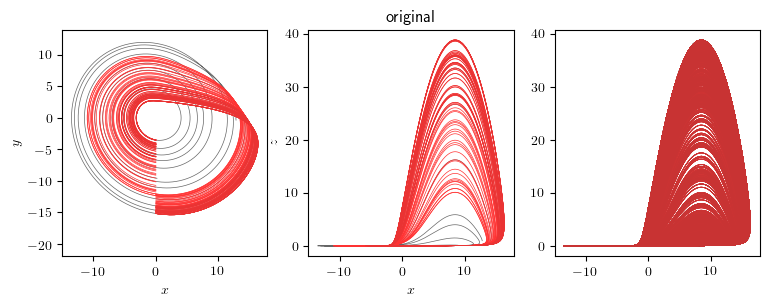

In [211]:
# Attractor with colors depending on the returning time
fig1 = plt.figure(figsize=(9,3), dpi=100)
ax1 = fig1.add_subplot(131)
ax1.plot(X1[-70000:,0], X1[-70000:,1], '-', c=(0.4,0.4,.4,1), lw=.5)

# Plot the slower trajectories
for kk in np.arange(6,2,-.5):
    slowIdx_0 = crossIdx[np.arange(timeBetCross.size)[timeBetCross<kk]]
    slowIdx_f = crossIdx[np.arange(1,timeBetCross.size+1)[timeBetCross<kk]]
    for k in range(slowIdx_0.size):
        ax1.plot(X1[np.arange(slowIdx_0[k],slowIdx_f[k]),0], X1[np.arange(slowIdx_0[k],slowIdx_f[k]),1], '-', c=(kk/6,0.2,.2,1), lw=.5)

ax1.set_ylim((-22,14))
ax1.set_xlabel('$x$'); ax1.set_ylabel('$y$');

# (x-y) plane
ax1 = fig1.add_subplot(132)
ax1.plot(X1[-70000:,0], X1[-70000:,2], '-', c=(0.4,0.4,.4,1), lw=.5)

# Plot the slower trajectories
for kk in np.arange(6,2,-.5):
    slowIdx_0 = crossIdx[np.arange(timeBetCross.size)[timeBetCross<kk]]
    slowIdx_f = crossIdx[np.arange(1,timeBetCross.size+1)[timeBetCross<kk]]
    for k in range(slowIdx_0.size):
        ax1.plot(X1[np.arange(slowIdx_0[k],slowIdx_f[k]),0], X1[np.arange(slowIdx_0[k],slowIdx_f[k]),2], '-', c=(kk/6,0.2,.2,1), lw=.5)

# ax1.set_ylim((-22,14))
ax1.set_xlabel('$x$'); ax1.set_ylabel('$z$'); ax1.set_title('original')

ax1 = fig1.add_subplot(133)
ax1.plot(X2[-70000:,0], X2[-70000:,2], '-', c=(0.4,0.4,.4,1), lw=.5)

# Plot the slower trajectories
for kk in np.arange(5.5,2,-.1):
    slowIdx_0 = crossIdx2[np.arange(timeBetCross2.size)[timeBetCross2<kk]]
    slowIdx_f = crossIdx2[np.arange(1,timeBetCross2.size+1)[timeBetCross2<kk]]
    for k in range(slowIdx_0.size):
        ax1.plot(X2[np.arange(slowIdx_0[k],slowIdx_f[k]),0], X2[np.arange(slowIdx_0[k],slowIdx_f[k]),2], '-', c=(kk/6,0.2,.2,1), lw=.5)

for kk in np.arange(7,6.2,-.1):
    slowIdx_0 = crossIdx2[np.arange(timeBetCross2.size)[timeBetCross2>kk]]
    slowIdx_f = crossIdx2[np.arange(1,timeBetCross2.size+1)[timeBetCross2>kk]]
    for k in range(slowIdx_0.size):
        ax1.plot(X2[np.arange(slowIdx_0[k],slowIdx_f[k]),0], X2[np.arange(slowIdx_0[k],slowIdx_f[k]),2], '-', c=(.2,.2,kk/7,1), lw=.5)

# ax1.set_ylim((-22,14))
ax1.set_xlabel('$x$'); ax1.set_ylabel('$z$');
ax1.set_title('modified ({:.2f},{:.2f})'.format(min(timeBetCross2),max(timeBetCross2)))

plt.show()

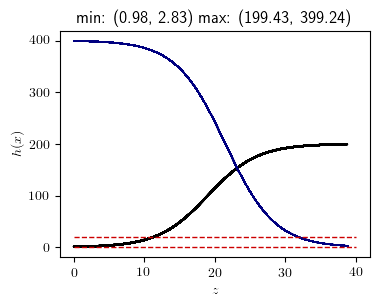

In [190]:
# PLOT: length vs radius (static) 
# auxHx = 1-(X1[:,2]**(1/6))/(130**(1/6))+.17
auxHx = 200.1+200*np.tanh((X1[:,2]-21.5)/7)
auxHx2 = 200.1-200*np.tanh((X1[:,2]-21.5)/7)

fig1 = plt.figure(figsize=(4,3), dpi=100)
ax1 = fig1.add_subplot(111)
ax1.plot(X1[:,2], auxHx, ':', c=(0.0,0.0,0.0,1), ms=1)
ax1.plot(X1[:,2], auxHx2, '-', c=(0.0,0.0,0.5,1), lw=1)
ax1.plot([0,40], [20,20], '--', c=(0.8,0.0,0.0,1), lw=1)
ax1.plot([0,40], [.98,.98], '--', c=(0.8,0.0,0.0,1), lw=1)
ax1.grid(False)
ax1.set_title('min: (%.2f, %.2f)     max: (%.2f, %.2f)'%(min(auxHx),min(auxHx2),max(auxHx),max(auxHx2)))
ax1.set_xlabel('$z$'); ax1.set_ylabel('$h(x)$')
plt.show()

In [ ]:
# NONCOHERENT SPIRAL - Plot the probability of recurrence
fig1 = plt.figure(figsize=(2.5,1), dpi=100)

ax1 = fig1.add_subplot(111) #add_axes([0.3,0.3,.7,.7])# add_subplot(111)
ax1.plot(tau2, pR2_a, '-', c=(0.9,0.5,0.0,1), lw=2)
ax1.plot(tau2, pR2_b, '-', c=(0,0.0,0.6,1), lw=.8)
ax1.set_xlabel(r'$\tau$'); ax1.set_ylabel(r'$P(\tau)$')
# ax1.set_title(r'Probability of Recurrence (RTC=%.3f)'%(sp.stats.pearsonr(pR2_a, pR2_b)[0][0]))
ax1.set_xlim((0,maxTau)); ax1.set_ylim((0,1))
ax1.grid(False) # grids on/off
fig1.savefig('fig/rossler_prob_recurrence_noncSpi_c.eps', format='eps', dpi=150, bbox_inches='tight')
plt.show()
print('RTC = %.4f'%sp.stats.pearsonr(pR2_a, pR2_b)[0][0])

In [ ]:
# ROSSLER SPIRAL - Plot the probability of recurrence
fig1 = plt.figure(figsize=(2.5,1), dpi=100)

ax1 = fig1.add_subplot(111)
ax1.plot(tau1, pR1_a, '-', c=(0.9,0.5,0.0,1), lw=2)
ax1.plot(tau1, pR1_b, '-', c=(0,0.0,0.6,1), lw=.8)
ax1.set_ylabel(r'$P(\tau)$')
ax1.set_xlim((0,maxTau)); ax1.set_ylim((0,1))
ax1.grid(False) # grids on/off
# ax1.set_xlabel(r'$\tau$');
# ax1.set_title(r'Probability of Recurrence (RTC=%.3f)'%(sp.stats.pearsonr(pR1_a, pR1_b)[0][0]))
ax1.set_xticks([])
plt.savefig('fig/rossler_prob_recurrence_rossSpi_a.eps', format='eps', dpi=150, bbox_inches='tight')
plt.show()
print('RTC = %.4f'%sp.stats.pearsonr(pR1_a, pR1_b)[0][0])

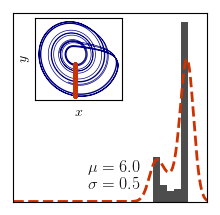

In [14]:
# PLOT: attractor, section and returning time
from scipy.stats import gaussian_kde

fig1 = plt.figure(figsize=(2.5,2.5), dpi=100)
ax1 = fig1.add_subplot(111)

# Fit a smooth density function
density = gaussian_kde(timeBetCross)
xs = np.linspace(0,8,200)
density.covariance_factor = lambda : .5; density._compute_covariance()
ax1.plot(xs,1.8*density(xs), '--', c=(.8,.2,0,1), lw=2)

# Histogram
muT = np.mean(timeBetCross)
stdT = np.std(timeBetCross)
n, bins, patches = ax1.hist(timeBetCross, bins=5, facecolor=(.3,0.3,0.3,1), normed=1) #bins='auto'

# ax1.set_xlabel('$T^{(\mathcal{P}_r)}$')
ax1.set_ylim((0,2.8)); ax1.set_xlim((0,7))
ax1.grid(False)
ax1.set_xticks([]); ax1.set_yticks([])

ax1.text(2.7, .2, '$\mu=%.1f$\n $\sigma=%.1f$'%(muT,stdT), fontsize=12, color=(0.1,0.1,0.1,1))

ax2 = fig1.add_axes([0.21, 0.53, 0.35, 0.33]) #[left, bottom, width, height] unitless percentages
ax2.plot(X1[-100000:,0], X1[-100000:,1], '-', c=(0.,0.0,0.5,1), lw=.5)
ax2.plot(X1[crossIdx,0], X1[crossIdx,1], 's', c=(.8,.2,0,1), ms=2)
ax2.set_xlabel('$x$'); ax2.set_ylabel('$y$')
ax2.grid(False); ax2.set_xticks([]); ax2.set_yticks([])

# plt.savefig('fig/rossler_returnTime_a.eps', format='eps', dpi=150)
plt.show()

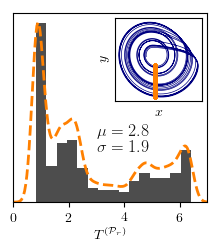

In [15]:
# PLOT: attractor, section and returning time
fig1 = plt.figure(figsize=(2.5,2.5), dpi=100)
ax1 = fig1.add_subplot(111)

# Fit a smooth density function
density = gaussian_kde(timeBetCross2)
xs = np.linspace(0,8,200)
density.covariance_factor = lambda : .1; density._compute_covariance()
ax1.plot(xs,1.4*density(xs), '--', c=(1,.5,0,1), lw=2)

# Histogram
muT = np.mean(timeBetCross2)
stdT = np.std(timeBetCross2)
n, bins, patches = ax1.hist(timeBetCross2, bins=15, facecolor=(.3,0.3,0.3,1), normed=1) #bins='auto'

ax1.set_xlabel('$T^{(\mathcal{P}_r)}$')
# ax1.set_ylim((0,3.1));
ax1.set_xlim((0,7))
ax1.grid(False)
ax1.set_yticks([])
# ax1.set_xlim((min(np.hstack((timeBetCross,timeBetCross2))),max(np.hstack((timeBetCross,timeBetCross2)))))

ax1.text(3., .22, '$\mu=%.1f$\n $\sigma=%.1f$'%(muT,stdT), fontsize=12, color=(0.1,0.1,0.1,1))

ax2 = fig1.add_axes([0.53, 0.53, 0.35, 0.33]) #[left, bottom, width, height] unitless percentages
ax2.plot(X2[100000:150000,0], X2[100000:150000,1], '-', c=(0.,0.0,0.5,1), lw=.5)
ax2.plot(X2[crossIdx2,0], X2[crossIdx2,1], 's', c=(1,.5,0,1), ms=2)

ax2.set_xlabel('$x$'); ax2.set_ylabel('$y$')
ax2.grid(False); ax2.set_xticks([]); ax2.set_yticks([])

# plt.savefig('fig/rossler_returnTime_c.eps', format='eps', dpi=150)
plt.show()

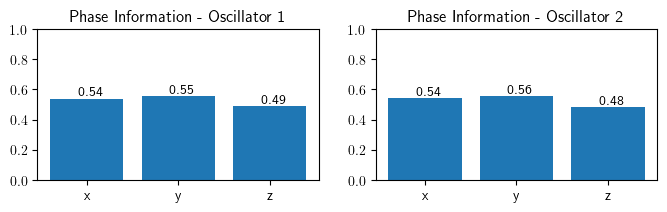

In [277]:
# Phase information 
# The sum of the phase information indexes 

plt.figure(figsize=(8,2), dpi=100)

plt.subplot(121)
plt.bar([1,2,3], [phInfo_X2_1_x_avg, phInfo_X2_1_y_avg, phInfo_X2_1_z_avg])
plt.xticks([1,2,3], ("x","y","z"));
plt.ylim(0,1)
plt.title("Phase Information - Oscillator 1");
plt.text(1-.1, phInfo_X2_1_x_avg+.02, "%.2f"%phInfo_X2_1_x_avg)
plt.text(2-.1, phInfo_X2_1_y_avg+.02, "%.2f"%phInfo_X2_1_y_avg)
plt.text(3-.1, phInfo_X2_1_z_avg+.02, "%.2f"%phInfo_X2_1_z_avg)

plt.subplot(122)
plt.bar([1,2,3], [phInfo_X2_2_x_avg, phInfo_X2_2_y_avg, phInfo_X2_2_z_avg])
plt.xticks([1,2,3], ("x","y","z"));
plt.ylim(0,1)
plt.title("Phase Information - Oscillator 2")
plt.text(1-.1, phInfo_X2_2_x_avg+.02, "%.2f"%phInfo_X2_2_x_avg)
plt.text(2-.1, phInfo_X2_2_y_avg+.02, "%.2f"%phInfo_X2_2_y_avg)
plt.text(3-.1, phInfo_X2_2_z_avg+.02, "%.2f"%phInfo_X2_2_z_avg);

#### Agora acabou.